# Poor Children Analysis: Wealth Quintile Method

## Configuration

In [1]:
import os

# ============================================================================
# CONFIGURATION
# ============================================================================

# Base directory where downloaded files are located
BASE_DIR = "data"

# Country identifier
COUNTRY = "JAM"

# Impact probability data configuration (optional - for calculating potentially impacted poor children)
DATE = "2025-10-27"  # Format: YYYY-MM-DD
FORECAST_TIME = "000000"  # Format: HHMMSS (e.g., "000000" for midnight, "120000" for noon)
WIND_THRESHOLDS = ["34", "50", "64"]  # List of wind thresholds in knots to compare
STORM = "MELISSA"  # Storm name

# ============================================================================
# POVERTY RATES BY CLASSIFICATION
# ============================================================================

# Moderate poverty rates (%) for children (ages 0-15) by area classification 2022
POVERTY_RATE_RURAL = 34.6460305820465
POVERTY_RATE_URBAN = 22.9166205159144
POVERTY_RATE_KMA = 34.5674892972073  # Kingston Metropolitan Area (Kingston + Saint Andrew)

POVERTY_RATES = {
    "Rural": POVERTY_RATE_RURAL,
    "Urban": POVERTY_RATE_URBAN,
    "KMA": POVERTY_RATE_KMA
}

# SMOD classification threshold (>= 20 = urban, < 20 = rural)
SMOD_URBAN_THRESHOLD = 20.0

# Kingston Metropolitan Area parishes
KMA_PARISHES = ["Kingston", "Saint Andrew"]

# Quintile data file
QUINTILE_EXCEL_PATH = os.path.join(BASE_DIR, "ChPov_JAM_CUB.xlsx")
QUINTILE_COUNTRY = "JAM"
QUINTILE_YEAR = 2022

## Import Libraries

In [2]:
import os
import math
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        plt.style.use('default')
sns.set_palette("husl")

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# ============================================================================
# VISUALIZATION SAVING SETUP
# ============================================================================
SAVE_VISUALIZATIONS = True
VISUALIZATIONS_DIR = "analysis_output/quintile_method/visualizations"

if SAVE_VISUALIZATIONS:
    os.makedirs(VISUALIZATIONS_DIR, exist_ok=True)
    print(f"Visualizations will be saved to: {VISUALIZATIONS_DIR}/")

# plt.show() wrapper for auto-saving
_original_show = plt.show

def _show_with_save(*args, **kwargs):
    """Wrapper around plt.show() that saves meaningful figures automatically"""
    if SAVE_VISUALIZATIONS:
        fig = plt.gcf()
        axes = fig.get_axes()
        filename = None
        
        if axes:
            try:
                if fig._suptitle is not None:
                    suptitle = fig._suptitle.get_text()
                    if suptitle and suptitle.strip():
                        filename = suptitle.lower().replace(' ', '_').replace('\n', '_')
                        filename = ''.join(c for c in filename if c.isalnum() or c in '_-')
            except:
                pass
            
            if not filename:
                for ax in axes:
                    try:
                        title = ax.get_title()
                        if title and title.strip():
                            filename = title.lower().replace(' ', '_').replace('\n', '_')
                            filename = ''.join(c for c in filename if c.isalnum() or c in '_-')
                            break
                    except:
                        pass
        
        if filename:
            filepath = os.path.join(VISUALIZATIONS_DIR, f"{filename}.png")
            fig.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"  Saved: {filepath}")
    
    return _original_show(*args, **kwargs)

if SAVE_VISUALIZATIONS:
    plt.show = _show_with_save

Visualizations will be saved to: analysis_output/quintile_method/visualizations/


## Load Data Files

In [3]:
# Construct file paths
admin_base_path = os.path.join(BASE_DIR, "geodb", "aos_views", "admin_views", f"{COUNTRY}_admin1.parquet")
tiles_base_path = os.path.join(BASE_DIR, "geodb", "aos_views", "mercator_views", f"{COUNTRY}_14.parquet")

print(f"Loading data files...")
print(f"  Admin boundaries: {admin_base_path}")
print(f"  Tiles: {tiles_base_path}")

# Load base admin boundaries
if os.path.exists(admin_base_path):
    gdf_admin = gpd.read_parquet(admin_base_path)
    print(f"\nLoaded admin boundaries: {len(gdf_admin)} parishes")
    print(f"   Columns: {list(gdf_admin.columns)}")
else:
    raise FileNotFoundError(f"Admin boundaries file not found: {admin_base_path}")

# Load base tiles with population and RWI
if os.path.exists(tiles_base_path):
    gdf_tiles = gpd.read_parquet(tiles_base_path)
    print(f"\nLoaded tiles: {len(gdf_tiles)} cells")
    print(f"   Columns: {list(gdf_tiles.columns)}")
else:
    raise FileNotFoundError(f"Tiles file not found: {tiles_base_path}")

Loading data files...
  Admin boundaries: data/geodb/aos_views/admin_views/JAM_admin1.parquet
  Tiles: data/geodb/aos_views/mercator_views/JAM_14.parquet

Loaded admin boundaries: 14 parishes
   Columns: ['tile_id', 'school_age_population', 'infant_population', 'built_surface_m2', 'population', 'num_schools', 'num_hcs', 'smod_class', 'rwi', 'name', 'geometry']

Loaded tiles: 2231 cells
   Columns: ['tile_id', 'school_age_population', 'infant_population', 'population', 'built_surface_m2', 'smod_class', 'num_schools', 'num_hcs', 'rwi', 'geometry', 'id']


## Prepare Data for Analysis

In [4]:
# Identify the correct column names
rwi_column = None
for col in gdf_tiles.columns:
    if col.lower() == 'rwi' or col.lower() == 'relative_wealth_index':
        rwi_column = col
        break

if rwi_column is None:
    rwi_cols = [col for col in gdf_tiles.columns if 'rwi' in col.lower()]
    if rwi_cols:
        rwi_column = rwi_cols[0]

infant_col = None
school_age_col = None
for col in gdf_tiles.columns:
    if 'infant' in col.lower() or '0-5' in col.lower():
        infant_col = col
    if 'school_age' in col.lower() or '5-15' in col.lower():
        school_age_col = col

tile_id_column = None
for col in gdf_tiles.columns:
    if col.lower() in ['tile_id', 'tileid', 'id', 'zone_id']:
        tile_id_column = col
        break

print(f"Identified columns:")
print(f"  RWI column: {rwi_column}")
print(f"  Infant population (0-5): {infant_col}")
print(f"  School age population (5-15): {school_age_col}")
print(f"  Tile ID column: {tile_id_column}")

if rwi_column is None:
    raise ValueError("Required column (RWI) not found")

if infant_col is None or school_age_col is None:
    raise ValueError("Required columns (infant_population and school_age_population) not found")

# Create a working copy
gdf_work = gdf_tiles.copy()
gdf_work['rwi'] = gdf_work[rwi_column]
gdf_work['infant_population'] = gdf_work[infant_col].fillna(0)
gdf_work['school_age_population'] = gdf_work[school_age_col].fillna(0)
gdf_work['children_population'] = gdf_work['infant_population'] + gdf_work['school_age_population']

if tile_id_column:
    gdf_work['tile_id'] = gdf_work[tile_id_column]
else:
    gdf_work['tile_id'] = gdf_work.index

# Remove rows with missing RWI or zero children population
gdf_work = gdf_work[gdf_work['rwi'].notna() & (gdf_work['children_population'] > 0)].copy()

print(f"\nPrepared {len(gdf_work)} tiles with valid RWI and children population data")
print(f"  Total children population: {gdf_work['children_population'].sum():,.0f}")
print(f"  - Ages 0-5: {gdf_work['infant_population'].sum():,.0f}")
print(f"  - Ages 5-15: {gdf_work['school_age_population'].sum():,.0f}")

Identified columns:
  RWI column: rwi
  Infant population (0-5): infant_population
  School age population (5-15): school_age_population
  Tile ID column: tile_id

Prepared 2224 tiles with valid RWI and children population data
  Total children population: 845,814
  - Ages 0-5: 217,525
  - Ages 5-15: 628,289


## Spatial Join: Assign Tiles to Parishes and Classify

In [5]:
# Perform spatial join to assign each tile to a parish
if gdf_work.crs != gdf_admin.crs:
    gdf_work = gdf_work.to_crs(gdf_admin.crs)

gdf_tiles_with_admin = gdf_work.copy()
gdf_tiles_with_admin['parish'] = None

print(f"Assigning {len(gdf_tiles_with_admin)} tiles to parishes...")

# For each tile, determine its parish assignment
for idx, tile_row in gdf_tiles_with_admin.iterrows():
    tile_geom = tile_row.geometry
    tile_centroid = tile_geom.centroid
    assigned_parish = None
    
    # Check if tile intersects any parish
    intersecting_parishes = []
    for admin_idx, admin_row in gdf_admin.iterrows():
        if tile_geom.intersects(admin_row.geometry):
            intersecting_parishes.append(admin_row['name'])
    
    if len(intersecting_parishes) == 1:
        assigned_parish = intersecting_parishes[0]
    elif len(intersecting_parishes) > 1:
        centroid_gdf = gpd.GeoDataFrame([{'geometry': tile_centroid}], crs=gdf_admin.crs)
        centroid_join = gpd.sjoin(centroid_gdf, gdf_admin[['name', 'geometry']], how='left', predicate='within')
        
        if len(centroid_join) > 0 and centroid_join['name'].iloc[0] is not None:
            assigned_parish = centroid_join['name'].iloc[0]
        else:
            min_dist = float('inf')
            for admin_idx, admin_row in gdf_admin.iterrows():
                if admin_row['name'] in intersecting_parishes:
                    dist = tile_centroid.distance(admin_row.geometry)
                    if dist < min_dist:
                        min_dist = dist
                        assigned_parish = admin_row['name']
    else:
        min_dist = float('inf')
        for admin_idx, admin_row in gdf_admin.iterrows():
            dist = tile_centroid.distance(admin_row.geometry)
            if dist < min_dist:
                min_dist = dist
                assigned_parish = admin_row['name']
    
    if assigned_parish:
        gdf_tiles_with_admin.loc[idx, 'parish'] = assigned_parish

# Verify all tiles have a parish
final_missing = gdf_tiles_with_admin['parish'].isna().sum()
if final_missing > 0:
    print(f"\nWarning: {final_missing} tiles missing parish assignment")
    for idx in gdf_tiles_with_admin[gdf_tiles_with_admin['parish'].isna()].index:
        tile_centroid = gdf_tiles_with_admin.loc[idx, 'geometry'].centroid
        min_dist = float('inf')
        nearest_parish = None
        for admin_idx, admin_row in gdf_admin.iterrows():
            dist = tile_centroid.distance(admin_row.geometry)
            if dist < min_dist:
                min_dist = dist
                nearest_parish = admin_row['name']
        if nearest_parish:
            gdf_tiles_with_admin.loc[idx, 'parish'] = nearest_parish

print(f"\n✓ All {len(gdf_tiles_with_admin)} tiles successfully assigned to parishes")
print(f"Parishes found:")
print(gdf_tiles_with_admin['parish'].value_counts().sort_index())

Assigning 2224 tiles to parishes...


✓ All 2224 tiles successfully assigned to parishes
Parishes found:
parish
Clarendon          240
Hanover            100
Kingston             4
Manchester         159
Portland           171
Saint Andrew        94
Saint Ann          240
Saint Catherine    239
Saint Elizabeth    235
Saint James        119
Saint Mary         131
Saint Thomas       157
Trelawny           170
Westmoreland       165
Name: count, dtype: int64


## Classify Tiles by Area Type (Rural/Urban/KMA)

In [6]:
def classify_area(parish, smod_class):
    """
    Classify tile as KMA, Urban, or Rural.
    Priority: KMA > Urban > Rural
    """
    if parish in KMA_PARISHES:
        return "KMA"
    
    if smod_class is None or math.isnan(smod_class):
        return "unknown"
    elif smod_class >= SMOD_URBAN_THRESHOLD:
        return "Urban"
    else:
        return "Rural"

# Classify each tile
gdf_tiles_with_admin['area_classification'] = gdf_tiles_with_admin.apply(
    lambda row: classify_area(row['parish'], row['smod_class']), axis=1
)

# Remove tiles with unknown classification
gdf_tiles_with_admin = gdf_tiles_with_admin[gdf_tiles_with_admin['area_classification'] != 'unknown'].copy()

# Print classification summary
print("=" * 60)
print("Area Classification Summary:")
print("=" * 60)
classification_counts = gdf_tiles_with_admin['area_classification'].value_counts()
for classification, count in classification_counts.items():
    children_pop = gdf_tiles_with_admin[gdf_tiles_with_admin['area_classification'] == classification]['children_population'].sum()
    print(f"{classification}:")
    print(f"  Tiles: {count}")
    print(f"  Children population: {children_pop:,.0f}")

# Calculate targets per classification
print("\n" + "=" * 60)
print("Target Calculation (Total children × Poverty rate):")
print("=" * 60)
classification_targets = {}
for classification in ['KMA', 'Urban', 'Rural']:
    classification_tiles = gdf_tiles_with_admin[gdf_tiles_with_admin['area_classification'] == classification]
    if len(classification_tiles) > 0:
        total_children_pop = classification_tiles['children_population'].sum()
        
        if classification == 'KMA':
            poverty_rate = POVERTY_RATE_KMA / 100
        elif classification == 'Urban':
            poverty_rate = POVERTY_RATE_URBAN / 100
        elif classification == 'Rural':
            poverty_rate = POVERTY_RATE_RURAL / 100
        
        target_poor_children = total_children_pop * poverty_rate
        classification_targets[classification] = target_poor_children
        
        print(f"\n{classification}:")
        print(f"  Total children population: {total_children_pop:,.0f}")
        print(f"  Poverty rate: {poverty_rate*100:.2f}%")
        print(f"  Target poor children: {target_poor_children:,.0f}")

Area Classification Summary:
Rural:
  Tiles: 1976
  Children population: 411,510
Urban:
  Tiles: 150
  Children population: 248,419
KMA:
  Tiles: 98
  Children population: 185,885

Target Calculation (Total children × Poverty rate):

KMA:
  Total children population: 185,885
  Poverty rate: 34.57%
  Target poor children: 64,256

Urban:
  Total children population: 248,419
  Poverty rate: 22.92%
  Target poor children: 56,929

Rural:
  Total children population: 411,510
  Poverty rate: 34.65%
  Target poor children: 142,572


## Load Wealth Quintile Poverty Data

Load poverty prevalence by wealth quintile from the Excel file.

In [7]:
def load_quintile_poverty_data(excel_path, country='JAM', year=2022):
    """
    Load poverty prevalence data by wealth quintile from Excel file, separated by subregion.
    
    Parameters:
    -----------
    excel_path : str
        Path to the Excel file (ChPov_JAM_CUB.xlsx)
    country : str
        Country code (default: 'JAM')
    year : int
        Year of data (default: 2022)
    
    Returns:
    --------
    quintile_poverty_by_subregion : dict
        Dictionary mapping subregion -> quintile (1-5) -> poverty prevalence rate (0-1)
        {
            'Rural': {1: 0.XX, 2: 0.XX, ..., 5: 0.XX},
            'Urban': {1: 0.XX, 2: 0.XX, ..., 5: 0.XX},
            'KMA': {1: 0.XX, 2: 0.XX, ..., 5: 0.XX}
        }
        Quintile 1 = Poorest, Quintile 5 = Richest
    """
    try:
        # Read Excel file
        df = pd.read_excel(excel_path)
        
        # Filter for country and year (note: columns are 'Country code' and 'Year')
        df_filtered = df[(df['Country code'] == country) & (df['Year'] == year)].copy()
        
        if len(df_filtered) == 0:
            raise ValueError(f"No data found for {country} in year {year}")
        
        # Filter for WEALTH_QUINTILE dimension
        df_quintile = df_filtered[df_filtered['Dimension'] == 'WEALTH_QUINTILE'].copy()
        
        if len(df_quintile) == 0:
            raise ValueError(f"No wealth quintile data found for {country} in year {year}")
        
        # Find the column for "Prevalence, moderate child poverty (%)"
        poverty_col = 'Prevalence, moderate child poverty (%)'
        
        if poverty_col not in df_quintile.columns:
            raise ValueError(f"Could not find poverty prevalence column. Available columns: {list(df_quintile.columns)}")
        
        # Map subregion names from Excel to our classification names
        subregion_mapping = {
            'Rural': 'Rural',
            'Urban': 'Urban',
            'Kingston Metropolitan Area (KMA)': 'KMA',
            '_T': 'Total'  # Overall total (for reference)
        }
        
        # Extract quintile and poverty data by subregion
        print(f"\nExtracting quintile data by subregion from {len(df_quintile)} rows:")
        print("="*60)
        
        quintile_poverty_by_subregion = {}
        
        for subregion_excel in df_quintile['SUBREGION_NAME'].unique():
            subregion_our = subregion_mapping.get(subregion_excel, subregion_excel)
            
            # Filter for this subregion
            df_subregion = df_quintile[df_quintile['SUBREGION_NAME'] == subregion_excel].copy()
            
            if len(df_subregion) == 0:
                continue
            
            quintile_poverty = {}
            print(f"\n{subregion_excel} ({subregion_our}):")
            
            for _, row in df_subregion.iterrows():
                subgroup = str(row['Subgroup']).strip()
                if subgroup.startswith('Q'):
                    try:
                        quintile = int(subgroup[1])  # Extract number from Q1, Q2, etc.
                        poverty_pct = float(row[poverty_col])
                        # Convert percentage to proportion
                        quintile_poverty[quintile] = poverty_pct / 100.0
                        print(f"  {subgroup} (Quintile {quintile}): {poverty_pct} %")
                    except (ValueError, KeyError) as e:
                        print(f"Warning: Could not parse quintile from subgroup '{subgroup}': {e}")
                        continue
            
            # Sort by quintile
            quintile_poverty = {k: quintile_poverty[k] for k in sorted(quintile_poverty.keys())}
            
            # Only store if we have all 5 quintiles and it's a subregion we care about
            if len(quintile_poverty) == 5 and subregion_our in ['Rural', 'Urban', 'KMA']:
                quintile_poverty_by_subregion[subregion_our] = quintile_poverty
            elif len(quintile_poverty) != 5:
                print(f"  Warning: Expected 5 quintiles for {subregion_our}, found {len(quintile_poverty)}")
        
        print("="*60)
        
        # Print final summary
        print(f"\nFinal quintile poverty data by subregion for {country} ({year}):")
        print("="*60)
        for subregion in ['Rural', 'Urban', 'KMA']:
            if subregion in quintile_poverty_by_subregion:
                print(f"\n{subregion}:")
                for q, rate in quintile_poverty_by_subregion[subregion].items():
                    q_label = "Poorest" if q == 1 else "Richest" if q == 5 else f"Q{q}"
                    print(f"  Quintile {q} ({q_label}): {rate*100} %")
        print("="*60)
        
        return quintile_poverty_by_subregion
        
    except Exception as e:
        print(f"Error loading quintile data: {e}")
        import traceback
        traceback.print_exc()
        raise

# Load the quintile data
quintile_poverty_data = load_quintile_poverty_data(
    QUINTILE_EXCEL_PATH, 
    country=QUINTILE_COUNTRY, 
    year=QUINTILE_YEAR
)


Extracting quintile data by subregion from 20 rows:

_T (Total):
  Q1 (Quintile 1): 60.34681792571042 %
  Q2 (Quintile 2): 36.431148259206125 %
  Q3 (Quintile 3): 25.995408160246214 %
  Q4 (Quintile 4): 16.35762914882909 %
  Q5 (Quintile 5): 9.96535092886287 %

Urban (Urban):
  Q1 (Quintile 1): 43.07819617303414 %
  Q2 (Quintile 2): 32.7468695487938 %
  Q3 (Quintile 3): 22.668764811417493 %
  Q4 (Quintile 4): 11.981063303732835 %
  Q5 (Quintile 5): 6.623603508222804 %

Rural (Rural):
  Q1 (Quintile 1): 61.239510019574226 %
  Q2 (Quintile 2): 32.710384423039486 %
  Q3 (Quintile 3): 22.426505082657012 %
  Q4 (Quintile 4): 18.434075235155728 %
  Q5 (Quintile 5): 11.608698774569355 %

Kingston Metropolitan Area (KMA) (KMA):
  Q1 (Quintile 1): 70.76172912580596 %
  Q2 (Quintile 2): 48.04475005416852 %
  Q3 (Quintile 3): 33.787232722163544 %
  Q4 (Quintile 4): 17.589608429936266 %
  Q5 (Quintile 5): 10.573253854992952 %

Final quintile poverty data by subregion for JAM (2022):

Rural:
  Qui

## Assign Poverty Rates by Quintile

For each region, divide RWI into quintiles and assign poverty rates based on quintile-specific prevalence.

In [8]:
def assign_poverty_by_quintile(df, rwi_col='rwi', classification_col='area_classification', 
                                quintile_poverty_by_subregion=None):
    """
    Assign poverty rates to each row based on RWI quintile, using subregion-specific rates.
    
    Uses POPULATION-WEIGHTED quintiles: tiles are sorted by RWI and divided so that
    each quintile contains approximately 20% of the children population.
    Each tile belongs to exactly one quintile.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame with RWI values, area classification, and children_population column
    rwi_col : str
        Name of RWI column (default: 'rwi')
    classification_col : str
        Name of area classification column (default: 'area_classification')
    quintile_poverty_by_subregion : dict
        Dictionary mapping subregion -> quintile (1-5) -> poverty rate (0-1)
        {
            'Rural': {1: 0.XX, 2: 0.XX, ..., 5: 0.XX},
            'Urban': {1: 0.XX, 2: 0.XX, ..., 5: 0.XX},
            'KMA': {1: 0.XX, 2: 0.XX, ..., 5: 0.XX}
        }
    
    Returns:
    --------
    df : DataFrame
        DataFrame with added 'wealth_quintile' and 'poverty_prob' columns
        Each row belongs to exactly one quintile (1-5)
    """
    df = df.copy()
    
    # Calculate POPULATION-WEIGHTED quintiles based on RWI distribution within each subregion
    # Lower RWI = poorer = lower quintile number
    df['wealth_quintile'] = 0
    df['poverty_prob'] = 0.0
    
    for subregion in ['Rural', 'Urban', 'KMA']:
        mask = df[classification_col] == subregion
        if mask.sum() == 0:
            continue
        
        if subregion not in quintile_poverty_by_subregion:
            print(f"Warning: No quintile data found for {subregion}")
            continue
        
        # Calculate POPULATION-WEIGHTED quintiles within this subregion
        # Sort by RWI (ascending: lowest RWI = poorest)
        df_subregion = df.loc[mask].copy()
        df_subregion = df_subregion.sort_values(rwi_col, ascending=True)
        
        # Calculate cumulative population
        df_subregion['cumulative_pop'] = df_subregion['children_population'].cumsum()
        total_pop = df_subregion['children_population'].sum()
        
        # Define population thresholds for quintiles (20%, 40%, 60%, 80%, 100%)
        thresholds = [0.2, 0.4, 0.6, 0.8, 1.0]
        pop_thresholds = [total_pop * t for t in thresholds]
        
        # Assign quintiles based on cumulative population
        # Each quintile should contain approximately 20% of the population
        df_subregion['wealth_quintile'] = 0
        
        # Initialize previous threshold
        prev_threshold = 0
        
        for i, threshold in enumerate(pop_thresholds):
            quintile = i + 1
            
            if i == 0:
                # First quintile: cumulative_pop <= 20%
                mask_q = df_subregion['cumulative_pop'] <= threshold
            else:
                # Subsequent quintiles: prev_threshold < cumulative_pop <= current_threshold
                mask_q = (df_subregion['cumulative_pop'] > prev_threshold) & (df_subregion['cumulative_pop'] <= threshold)
            
            df_subregion.loc[mask_q, 'wealth_quintile'] = quintile
            prev_threshold = threshold
        
        # Ensure all rows have a quintile (handle edge cases - should be rare)
        unassigned = df_subregion['wealth_quintile'] == 0
        if unassigned.sum() > 0:
            print(f"  Warning: {unassigned.sum()} rows in {subregion} not assigned to quintile, assigning to Q5")
            df_subregion.loc[unassigned, 'wealth_quintile'] = 5
        
        # Assign poverty rates based on quintile for this subregion
        quintile_poverty = quintile_poverty_by_subregion[subregion]
        df_subregion['poverty_prob'] = df_subregion['wealth_quintile'].map(quintile_poverty)
        
        # Update the main dataframe using index to ensure correct mapping
        # Since df_subregion was sorted but indices are preserved, we can use .loc with index
        df.loc[df_subregion.index, 'wealth_quintile'] = df_subregion['wealth_quintile']
        df.loc[df_subregion.index, 'poverty_prob'] = df_subregion['poverty_prob']
    
    # Handle any missing values
    if df['poverty_prob'].isna().any():
        print(f"Warning: {df['poverty_prob'].isna().sum()} rows have missing poverty rates")
        df['poverty_prob'] = df['poverty_prob'].fillna(0.0)
    
    return df

# Initialize results
gdf_results = gdf_tiles_with_admin.copy()
gdf_results['poverty_prob'] = 0.0
gdf_results['wealth_quintile'] = 0

calibration_stats = []

print("\n" + "="*60)
print("Assigning Poverty Rates by Quintile for Each Region")
print("="*60)

for region in ['Rural', 'Urban', 'KMA']:
    # Filter Region
    mask = gdf_results['area_classification'] == region
    df_region = gdf_results[mask].copy()
    
    if len(df_region) == 0:
        continue
    
    # Get target rate
    if region == 'KMA':
        target_rate = POVERTY_RATE_KMA / 100
    elif region == 'Urban':
        target_rate = POVERTY_RATE_URBAN / 100
    else:
        target_rate = POVERTY_RATE_RURAL / 100
    
    # Calculate Target
    total_pop = df_region['children_population'].sum()
    target_poor = total_pop * target_rate
    
    # Assign poverty rates based on quintiles (using subregion-specific rates)
    df_region = assign_poverty_by_quintile(
        df_region, 
        rwi_col='rwi', 
        classification_col='area_classification',
        quintile_poverty_by_subregion=quintile_poverty_data
    )
    
    # Update main dataframe
    gdf_results.loc[mask, 'poverty_prob'] = df_region['poverty_prob'].values
    gdf_results.loc[mask, 'wealth_quintile'] = df_region['wealth_quintile'].values
    
    # Calculate expected poor children
    estimated_poor = (df_region['poverty_prob'] * df_region['children_population']).sum()
    
    # Calculate quintile distribution
    quintile_dist = df_region.groupby('wealth_quintile').agg({
        'children_population': 'sum',
        'poverty_prob': 'first'
    }).reset_index()
    
    calibration_stats.append({
        'Region': region,
        'Target': target_poor,
        'Achieved': estimated_poor,
        'Difference': estimated_poor - target_poor,
        'Difference_Pct': ((estimated_poor - target_poor) / target_poor * 100) if target_poor > 0 else 0,
        'Total_Children': total_pop
    })
    
    print(f"\n{region}:")
    print(f"  Target poor children: {target_poor:,.0f} ({target_rate*100:.2f}%)")
    print(f"  Achieved poor children: {estimated_poor:,.0f}")
    print(f"  Difference: {estimated_poor - target_poor:,.0f} ({(estimated_poor - target_poor) / target_poor * 100:.2f}%)")
    print(f"  Quintile distribution:")
    for _, q_row in quintile_dist.iterrows():
        q = int(q_row['wealth_quintile'])
        q_pop = q_row['children_population']
        q_poverty_rate = q_row['poverty_prob']
        q_poor = q_pop * q_poverty_rate
        q_label = "Poorest" if q == 1 else "Richest" if q == 5 else f"Q{q}"
        print(f"    Q{q} ({q_label}): {q_poor:,.0f} poor children ({q_poverty_rate*100:.1f}% poverty rate, {q_pop:,.0f} total children)")

df_stats = pd.DataFrame(calibration_stats)
print("\n" + "-"*60)
print("Summary Statistics:")
print(df_stats.to_string(index=False))


Assigning Poverty Rates by Quintile for Each Region

Rural:
  Target poor children: 142,572 (34.65%)
  Achieved poor children: 120,374
  Difference: -22,198 (-15.57%)
  Quintile distribution:
    Q1 (Poorest): 50,385 poor children (61.2% poverty rate, 82,275 total children)
    Q2 (Q2): 26,637 poor children (32.7% poverty rate, 81,434 total children)
    Q3 (Q3): 18,632 poor children (22.4% poverty rate, 83,081 total children)
    Q4 (Q4): 15,119 poor children (18.4% poverty rate, 82,017 total children)
    Q5 (Richest): 9,601 poor children (11.6% poverty rate, 82,704 total children)

Urban:
  Target poor children: 56,929 (22.92%)
  Achieved poor children: 57,829
  Difference: 900 (1.58%)
  Quintile distribution:
    Q1 (Poorest): 20,969 poor children (43.1% poverty rate, 48,676 total children)
    Q2 (Q2): 16,402 poor children (32.7% poverty rate, 50,087 total children)
    Q3 (Q3): 11,069 poor children (22.7% poverty rate, 48,828 total children)
    Q4 (Q4): 6,064 poor children (12.

## Visualize population distribution across quintiles and RWI distributions

  Saved: analysis_output/quintile_method/visualizations/population_distribution_by_quintile.png


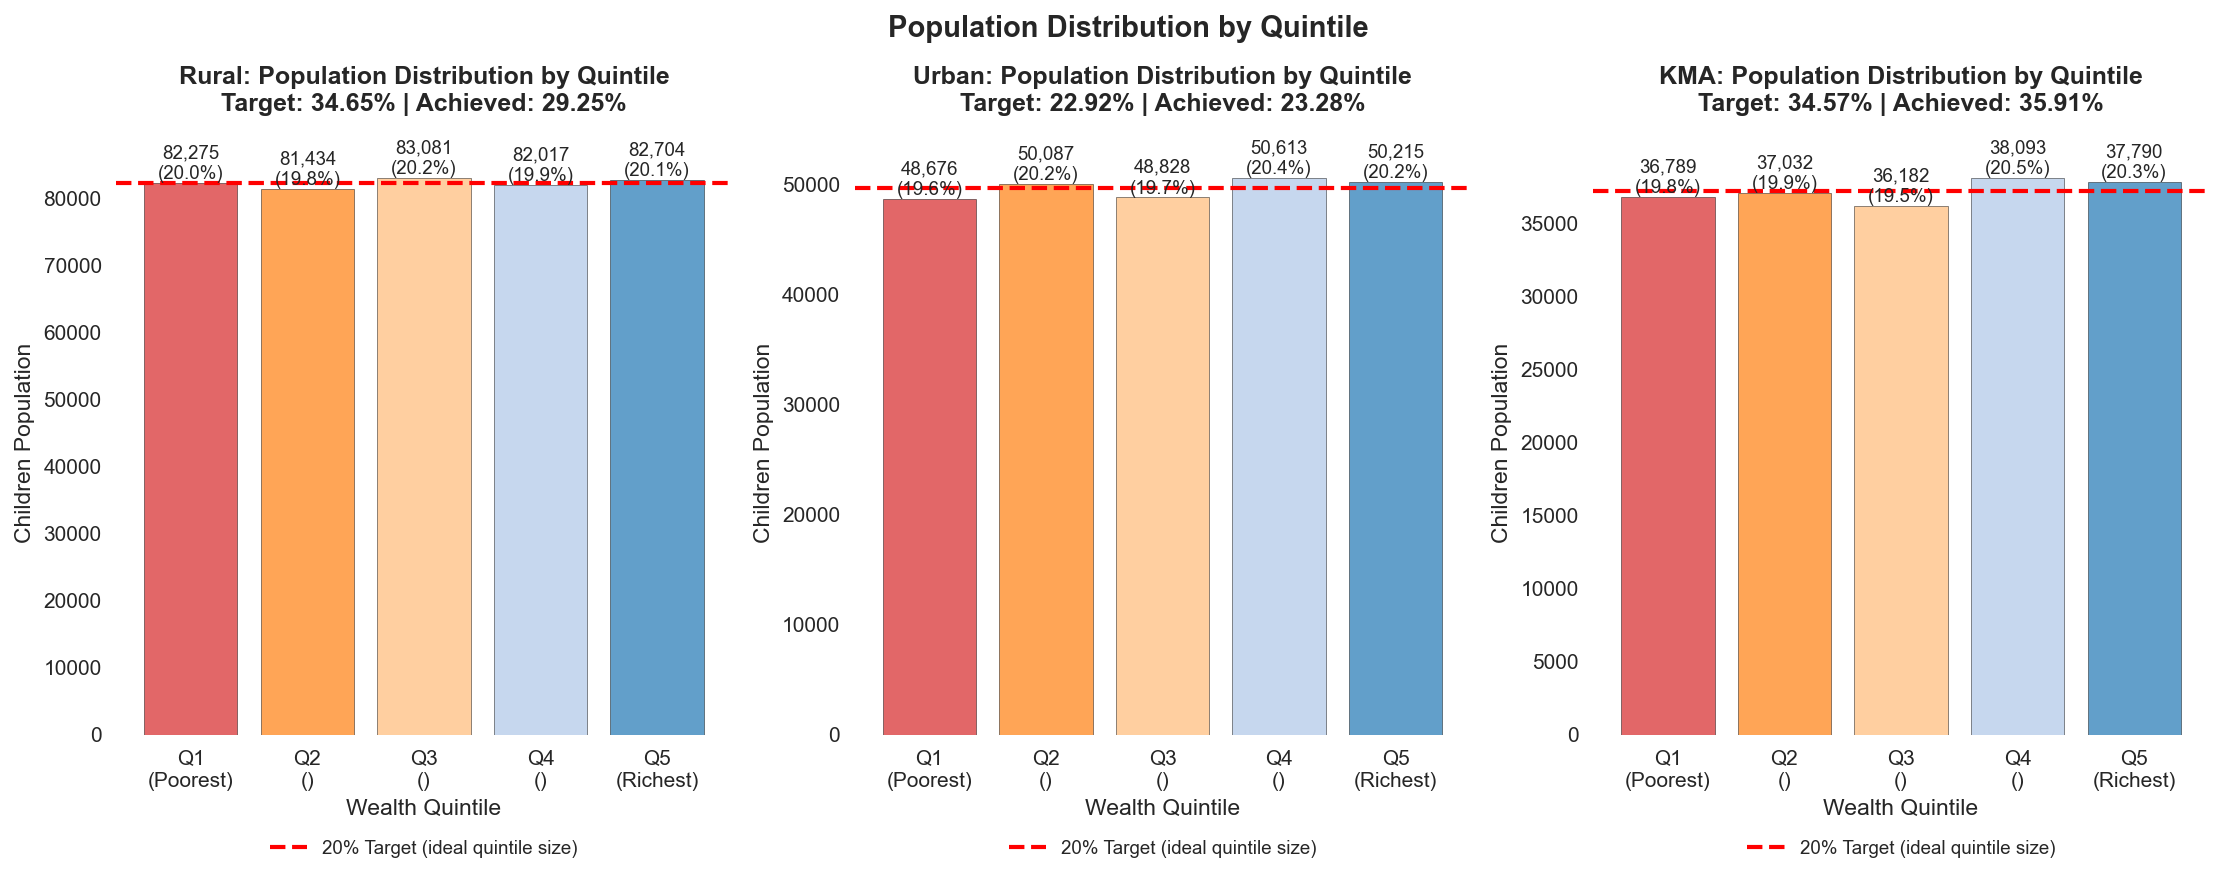

In [9]:
# Calculate poor children for each cell
gdf_results['poor_children'] = gdf_results['poverty_prob'] * gdf_results['children_population']

# Diagnostic: Population distribution by quintile for each region
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, region in enumerate(['Rural', 'Urban', 'KMA']):
    mask = gdf_results['area_classification'] == region
    df_region = gdf_results[mask].copy()
    
    if len(df_region) == 0:
        continue
    
    # Get target rate
    if region == 'KMA':
        target_rate = POVERTY_RATE_KMA / 100
    elif region == 'Urban':
        target_rate = POVERTY_RATE_URBAN / 100
    else:
        target_rate = POVERTY_RATE_RURAL / 100
    
    # Group by quintile
    quintile_summary = df_region.groupby('wealth_quintile').agg({
        'children_population': 'sum',
        'poor_children': 'sum',
        'poverty_prob': 'first',
        'rwi': ['min', 'max', 'mean', 'median']
    }).reset_index()
    
    quintile_summary.columns = ['quintile', 'total_children', 'poor_children', 'poverty_rate', 
                                 'rwi_min', 'rwi_max', 'rwi_mean', 'rwi_median']
    
    # Calculate what poverty rate we'd get if quintiles were perfectly 20% each
    total_pop = df_region['children_population'].sum()
    expected_poverty_rate = (quintile_summary['poor_children'].sum() / total_pop)
    
    # Population distribution across quintiles
    ax1 = axes[idx]
    colors = ['#d62728', '#ff7f0e', '#ffbb78', '#aec7e8', '#1f77b4']
    bars = ax1.bar(quintile_summary['quintile'], quintile_summary['total_children'], 
                   color=colors, alpha=0.7, edgecolor='black')
    
    # Add percentage labels
    for bar, pop in zip(bars, quintile_summary['total_children']):
        height = bar.get_height()
        pct = (pop / total_pop * 100)
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{pop:,.0f}\n({pct:.1f}%)',
                ha='center', va='bottom', fontsize=9)
    
    # Add 20% reference line
    ax1.axhline(y=total_pop * 0.2, color='red', linestyle='--', linewidth=2, 
                label='20% Target (ideal quintile size)')
    
    ax1.set_xlabel('Wealth Quintile', fontsize=11)
    ax1.set_ylabel('Children Population', fontsize=11)
    ax1.set_title(f'{region}: Population Distribution by Quintile\n'
                  f'Target: {target_rate*100:.2f}% | Achieved: {expected_poverty_rate*100:.2f}%\n', 
                  fontsize=12, fontweight='bold')
    ax1.set_xticks(quintile_summary['quintile'])
    ax1.set_xticklabels([f'Q{q}\n({"Poorest" if q == 1 else "Richest" if q == 5 else ""})' 
                         for q in quintile_summary['quintile']])

    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1, fontsize=9)
    ax1.grid(True, alpha=0.3, axis='y')

plt.subplots_adjust(top=0.85, bottom=0.2)
plt.suptitle('Population Distribution by Quintile', 
             fontsize=14, fontweight='bold', y=1)
plt.show()

In [10]:
for region in ['Rural', 'Urban', 'KMA']:
    mask = gdf_results['area_classification'] == region
    df_region = gdf_results[mask].copy()
    
    if len(df_region) == 0:
        continue
    
    # Get target rate
    if region == 'KMA':
        target_rate = POVERTY_RATE_KMA / 100
    elif region == 'Urban':
        target_rate = POVERTY_RATE_URBAN / 100
    else:
        target_rate = POVERTY_RATE_RURAL / 100
    
    total_pop = df_region['children_population'].sum()
    target_poor = total_pop * target_rate
    
    # Group by quintile
    quintile_summary = df_region.groupby('wealth_quintile').agg({
        'children_population': 'sum',
        'poor_children': 'sum',
        'poverty_prob': 'first',
        'rwi': ['min', 'max', 'mean']
    }).reset_index()
    
    quintile_summary.columns = ['quintile', 'pop', 'poor', 'poverty_rate', 'rwi_min', 'rwi_max', 'rwi_mean']
    
    perfect_pop_per_quintile = total_pop / 5
    perfect_poor = (quintile_summary['poverty_rate'] * perfect_pop_per_quintile).sum()
    perfect_rate = perfect_poor / total_pop
    
    # Actual distribution
    actual_poor = quintile_summary['poor'].sum()
    actual_rate = actual_poor / total_pop
    
    print(f"\n{region}:")
    print(f"  Target poverty rate: {target_rate*100:.2f}%")
    print(f"  Actual achieved rate: {actual_rate*100:.2f}%")
    print(f"  Error: {(actual_rate - target_rate)*100:.2f} percentage points")
    
    print(f"\n  Actual population distribution:")
    for _, row in quintile_summary.iterrows():
        q = int(row['quintile'])
        pop_pct = (row['pop'] / total_pop * 100)
        poverty_rate = row['poverty_rate']
        poor = row['poor']
        rwi_range = f"{row['rwi_min']:.2f} to {row['rwi_max']:.2f}"
        q_label = "Poorest" if q == 1 else "Richest" if q == 5 else f"Q{q}"
        print(f"    Q{q} ({q_label}): {row['pop']:,.0f} children ({pop_pct:.1f}%) | "
              f"Poverty rate: {poverty_rate*100:.1f}% | Poor: {poor:,.0f} | RWI: {rwi_range}")


Rural:
  Target poverty rate: 34.65%
  Actual achieved rate: 29.25%
  Error: -5.39 percentage points

  Actual population distribution:
    Q1 (Poorest): 82,275 children (20.0%) | Poverty rate: 61.2% | Poor: 50,385 | RWI: -1.04 to -0.06
    Q2 (Q2): 81,434 children (19.8%) | Poverty rate: 32.7% | Poor: 26,637 | RWI: -0.06 to 0.14
    Q3 (Q3): 83,081 children (20.2%) | Poverty rate: 22.4% | Poor: 18,632 | RWI: 0.14 to 0.34
    Q4 (Q4): 82,017 children (19.9%) | Poverty rate: 18.4% | Poor: 15,119 | RWI: 0.35 to 0.57
    Q5 (Richest): 82,704 children (20.1%) | Poverty rate: 11.6% | Poor: 9,601 | RWI: 0.57 to 1.34

Urban:
  Target poverty rate: 22.92%
  Actual achieved rate: 23.28%
  Error: 0.36 percentage points

  Actual population distribution:
    Q1 (Poorest): 48,676 children (19.6%) | Poverty rate: 43.1% | Poor: 20,969 | RWI: -0.14 to 0.56
    Q2 (Q2): 50,087 children (20.2%) | Poverty rate: 32.7% | Poor: 16,402 | RWI: 0.57 to 0.74
    Q3 (Q3): 48,828 children (19.7%) | Poverty rate

## How RWI Maps to Quintiles

  Saved: analysis_output/quintile_method/visualizations/how_rwi_maps_to_population-weighted_quintiles.png


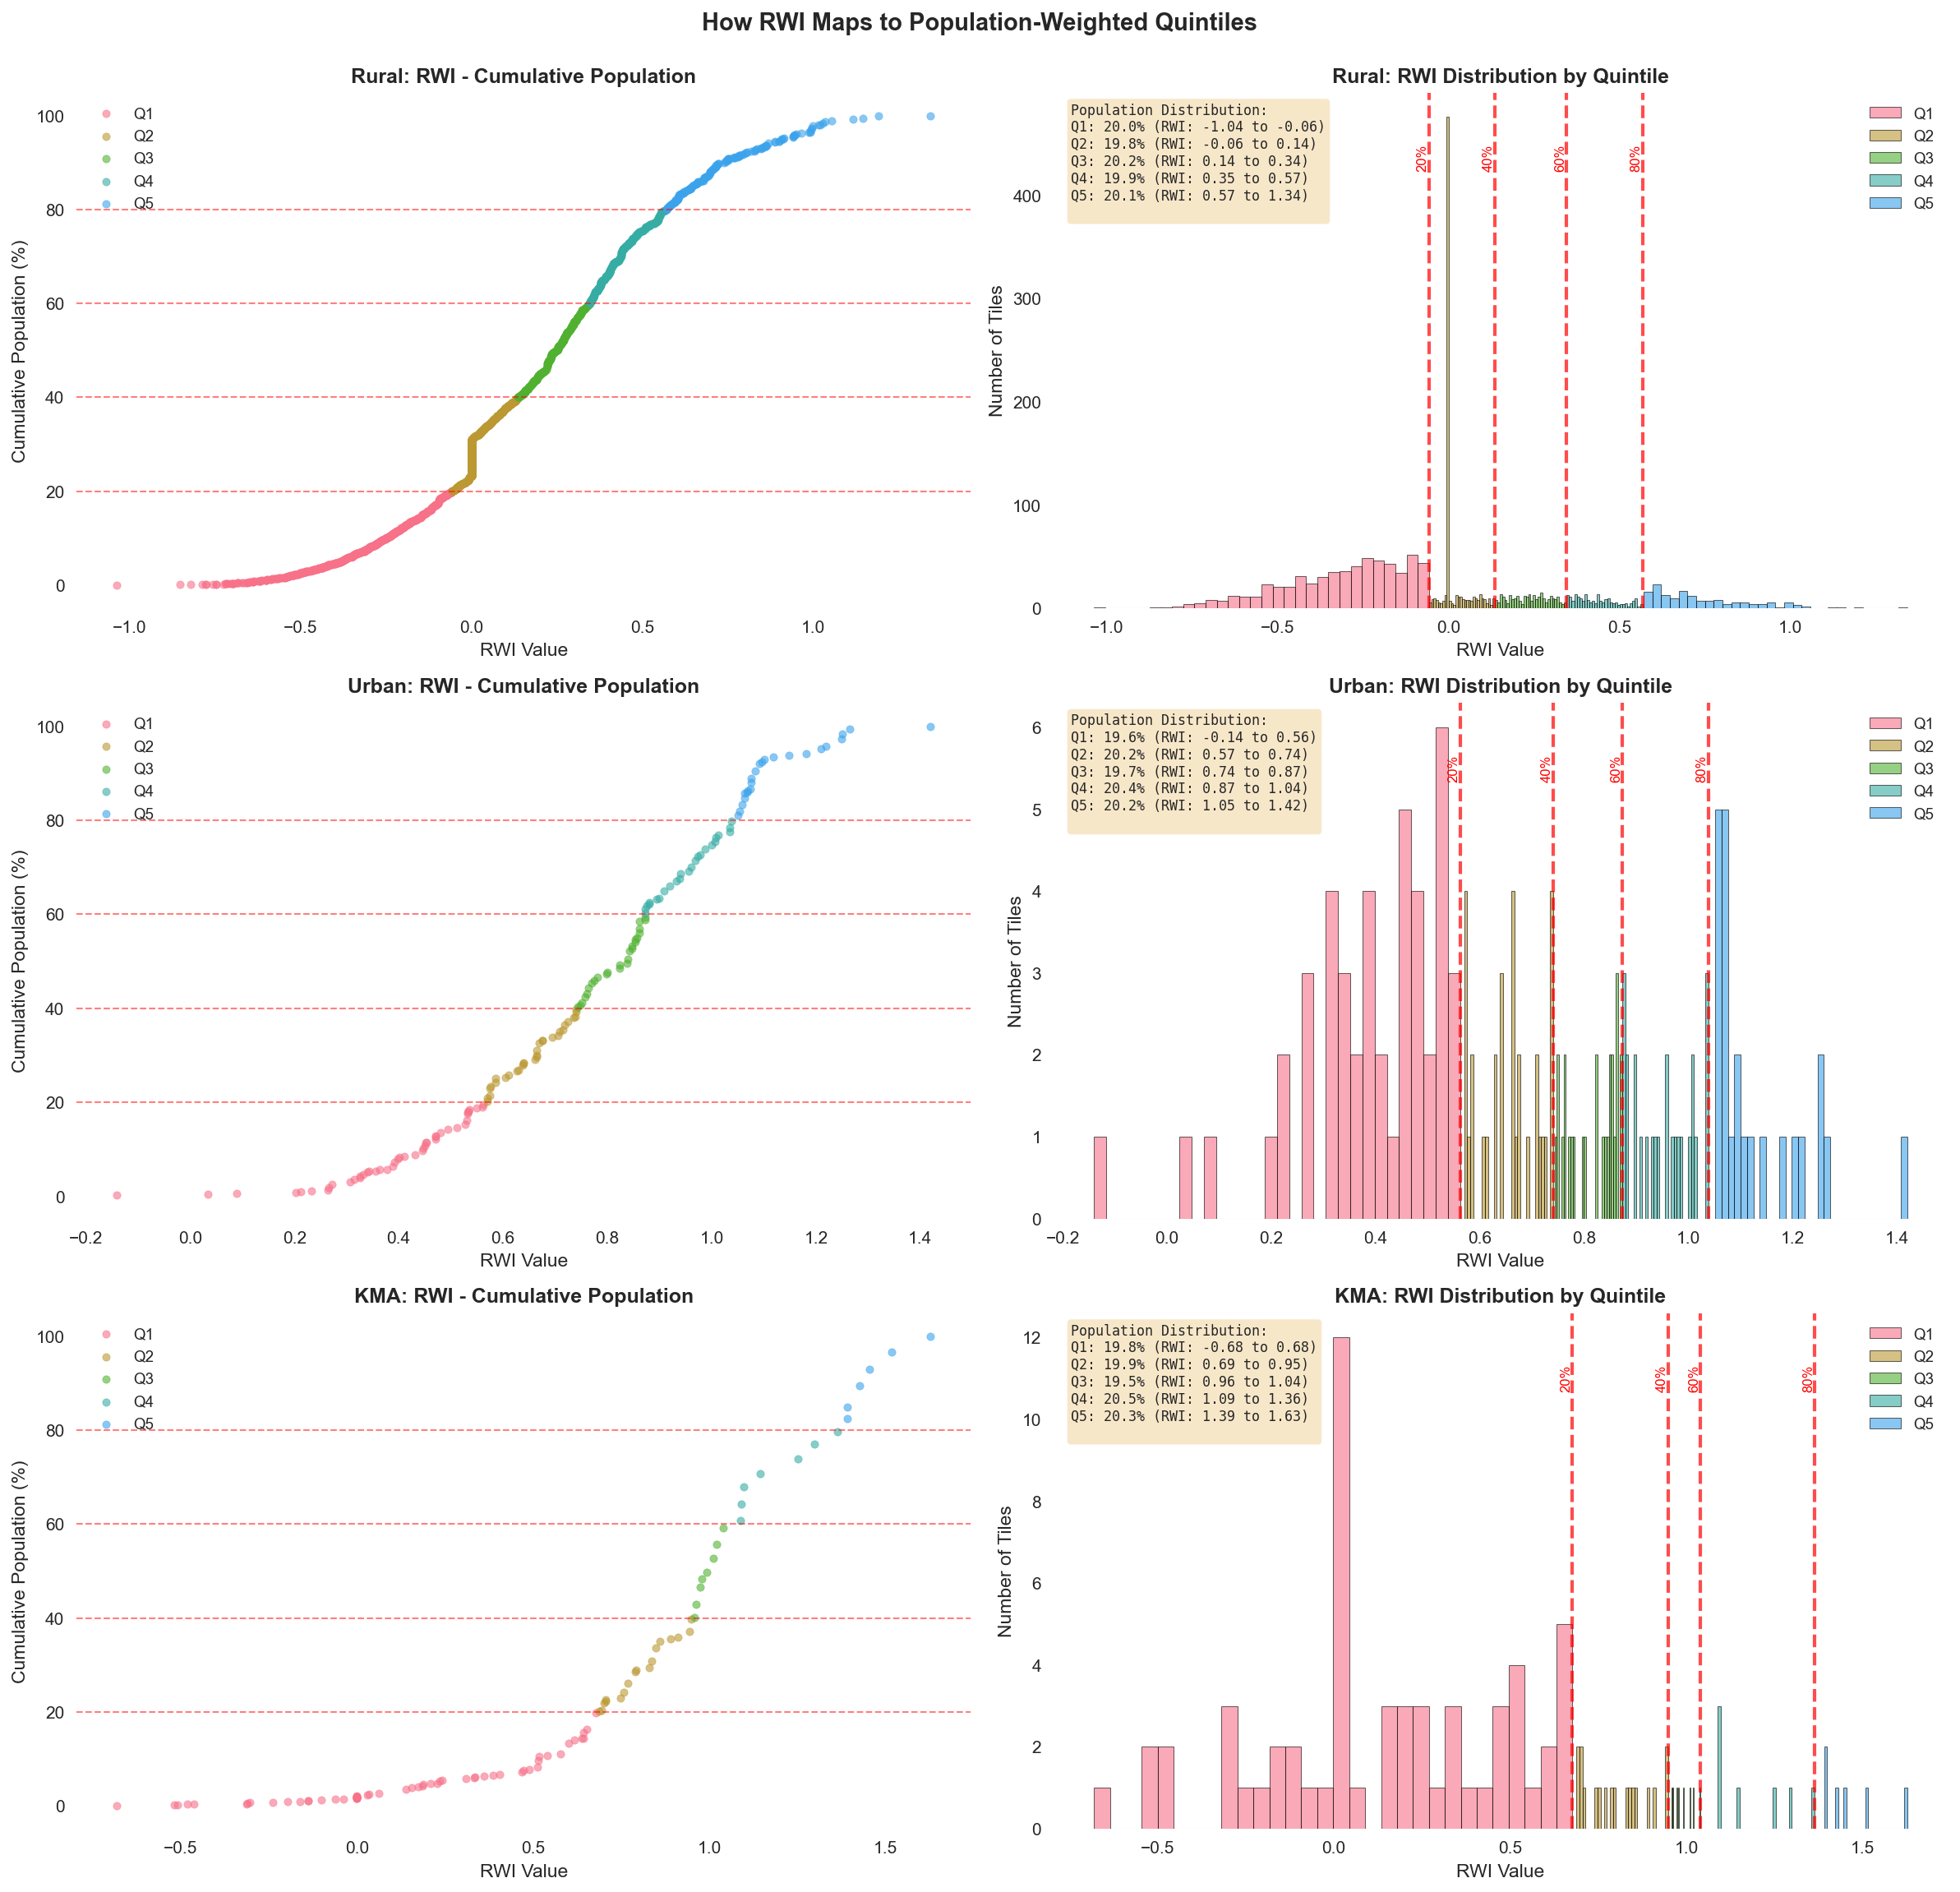

In [11]:
# Detailed visualization: How RWI maps to quintiles
fig, axes = plt.subplots(3, 2, figsize=(16, 15))

for idx, region in enumerate(['Rural', 'Urban', 'KMA']):
    mask = gdf_results['area_classification'] == region
    df_region = gdf_results[mask].copy()
    
    if len(df_region) == 0:
        continue
    
    # Sort by RWI to see the mapping
    df_region_sorted = df_region.sort_values('rwi', ascending=True).copy()
    df_region_sorted['cumulative_pop'] = df_region_sorted['children_population'].cumsum()
    total_pop = df_region_sorted['children_population'].sum()
    
    # Left plot: RWI vs Cumulative Population (showing quintile boundaries)
    ax1 = axes[idx, 0]
    
    # Color by quintile
    for q in sorted(df_region_sorted['wealth_quintile'].unique()):
        q_mask = df_region_sorted['wealth_quintile'] == q
        ax1.scatter(df_region_sorted.loc[q_mask, 'rwi'], 
                   df_region_sorted.loc[q_mask, 'cumulative_pop'] / total_pop * 100,
                   label=f'Q{q}', alpha=0.6, s=20)
    
    # Add quintile boundary lines (20%, 40%, 60%, 80%)
    for threshold in [20, 40, 60, 80]:
        ax1.axhline(y=threshold, color='red', linestyle='--', linewidth=1, alpha=0.5)
    
    ax1.set_xlabel('RWI Value', fontsize=11)
    ax1.set_ylabel('Cumulative Population (%)', fontsize=11)
    ax1.set_title(f'{region}: RWI - Cumulative Population', 
                  fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9, loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Right plot: RWI distribution with quintile boundaries
    ax2 = axes[idx, 1]
    
    # Create histogram of RWI values, colored by quintile
    for q in sorted(df_region_sorted['wealth_quintile'].unique()):
        q_mask = df_region_sorted['wealth_quintile'] == q
        q_rwi = df_region_sorted.loc[q_mask, 'rwi'].values
        if len(q_rwi) > 0:
            ax2.hist(q_rwi, bins=30, alpha=0.6, label=f'Q{q}', 
                    edgecolor='black', linewidth=0.5)
    
    # Add vertical lines for quintile boundaries (approximate)
    # Find RWI values at population thresholds
    thresholds_pct = [20, 40, 60, 80]
    for threshold_pct in thresholds_pct:
        threshold_pop = total_pop * threshold_pct / 100
        # Find the RWI value where cumulative population crosses this threshold
        crossing_idx = (df_region_sorted['cumulative_pop'] <= threshold_pop).sum() - 1
        if crossing_idx >= 0 and crossing_idx < len(df_region_sorted):
            rwi_boundary = df_region_sorted.iloc[crossing_idx]['rwi']
            ax2.axvline(x=rwi_boundary, color='red', linestyle='--', linewidth=2, alpha=0.7)
            ax2.text(rwi_boundary, ax2.get_ylim()[1] * 0.9, f'{threshold_pct}%',
                    rotation=90, va='top', ha='right', fontsize=8, color='red')
    
    ax2.set_xlabel('RWI Value', fontsize=11)
    ax2.set_ylabel('Number of Tiles', fontsize=11)
    ax2.set_title(f'{region}: RWI Distribution by Quintile', 
                  fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add summary statistics
    quintile_summary = df_region.groupby('wealth_quintile').agg({
        'children_population': 'sum',
        'rwi': ['min', 'max', 'mean']
    }).reset_index()
    
    # Flatten MultiIndex columns
    quintile_summary.columns = ['wealth_quintile', 'children_population', 'rwi_min', 'rwi_max', 'rwi_mean']
    
    summary_text = f"Population Distribution:\n"
    for _, row in quintile_summary.iterrows():
        q = int(row['wealth_quintile'])
        pop = float(row['children_population'])
        pop_pct = (pop / total_pop * 100)
        rwi_min = float(row['rwi_min'])
        rwi_max = float(row['rwi_max'])
        summary_text += f"Q{q}: {pop_pct:.1f}% (RWI: {rwi_min:.2f} to {rwi_max:.2f})\n"
    
    ax2.text(0.02, 0.98, summary_text, transform=ax2.transAxes,
            fontsize=8, verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.suptitle('How RWI Maps to Population-Weighted Quintiles', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

## Calculate Poor Children per Tile

In [12]:
# Calculate poor children for each cell: poverty_rate × children_population
gdf_results['poor_children'] = gdf_results['poverty_prob'] * gdf_results['children_population']

# Add flag for tiles with poor children
gdf_results['has_poor_children'] = gdf_results['poor_children'] > 0

print("="*60)
print("Poor Children Calculation Summary")
print("="*60)
print(f"Total tiles: {len(gdf_results)}")
print(f"Tiles with poor children: {gdf_results['has_poor_children'].sum()}")
print(f"Total children population: {gdf_results['children_population'].sum():,.0f}")
print(f"Total poor children (sum across all tiles): {gdf_results['poor_children'].sum():,.0f}")

print("\nBy Classification:")
for classification in ['Rural', 'Urban', 'KMA']:
    mask = gdf_results['area_classification'] == classification
    if mask.sum() > 0:
        total_children = gdf_results[mask]['children_population'].sum()
        total_poor = gdf_results[mask]['poor_children'].sum()
        poverty_rate = (total_poor / total_children * 100) if total_children > 0 else 0
        print(f"  {classification}: {total_poor:,.0f} poor children ({poverty_rate:.2f}% of {total_children:,.0f} total)")

Poor Children Calculation Summary
Total tiles: 2224
Tiles with poor children: 2224
Total children population: 845,814
Total poor children (sum across all tiles): 244,948

By Classification:
  Rural: 120,374 poor children (29.25% of 411,510 total)
  Urban: 57,829 poor children (23.28% of 248,419 total)
  KMA: 66,745 poor children (35.91% of 185,885 total)


## RWI Distribution by Quintile: Which Cells are Selected for Which Quintile

  Saved: analysis_output/quintile_method/visualizations/rwi_distribution_by_quintile_assignment_.png


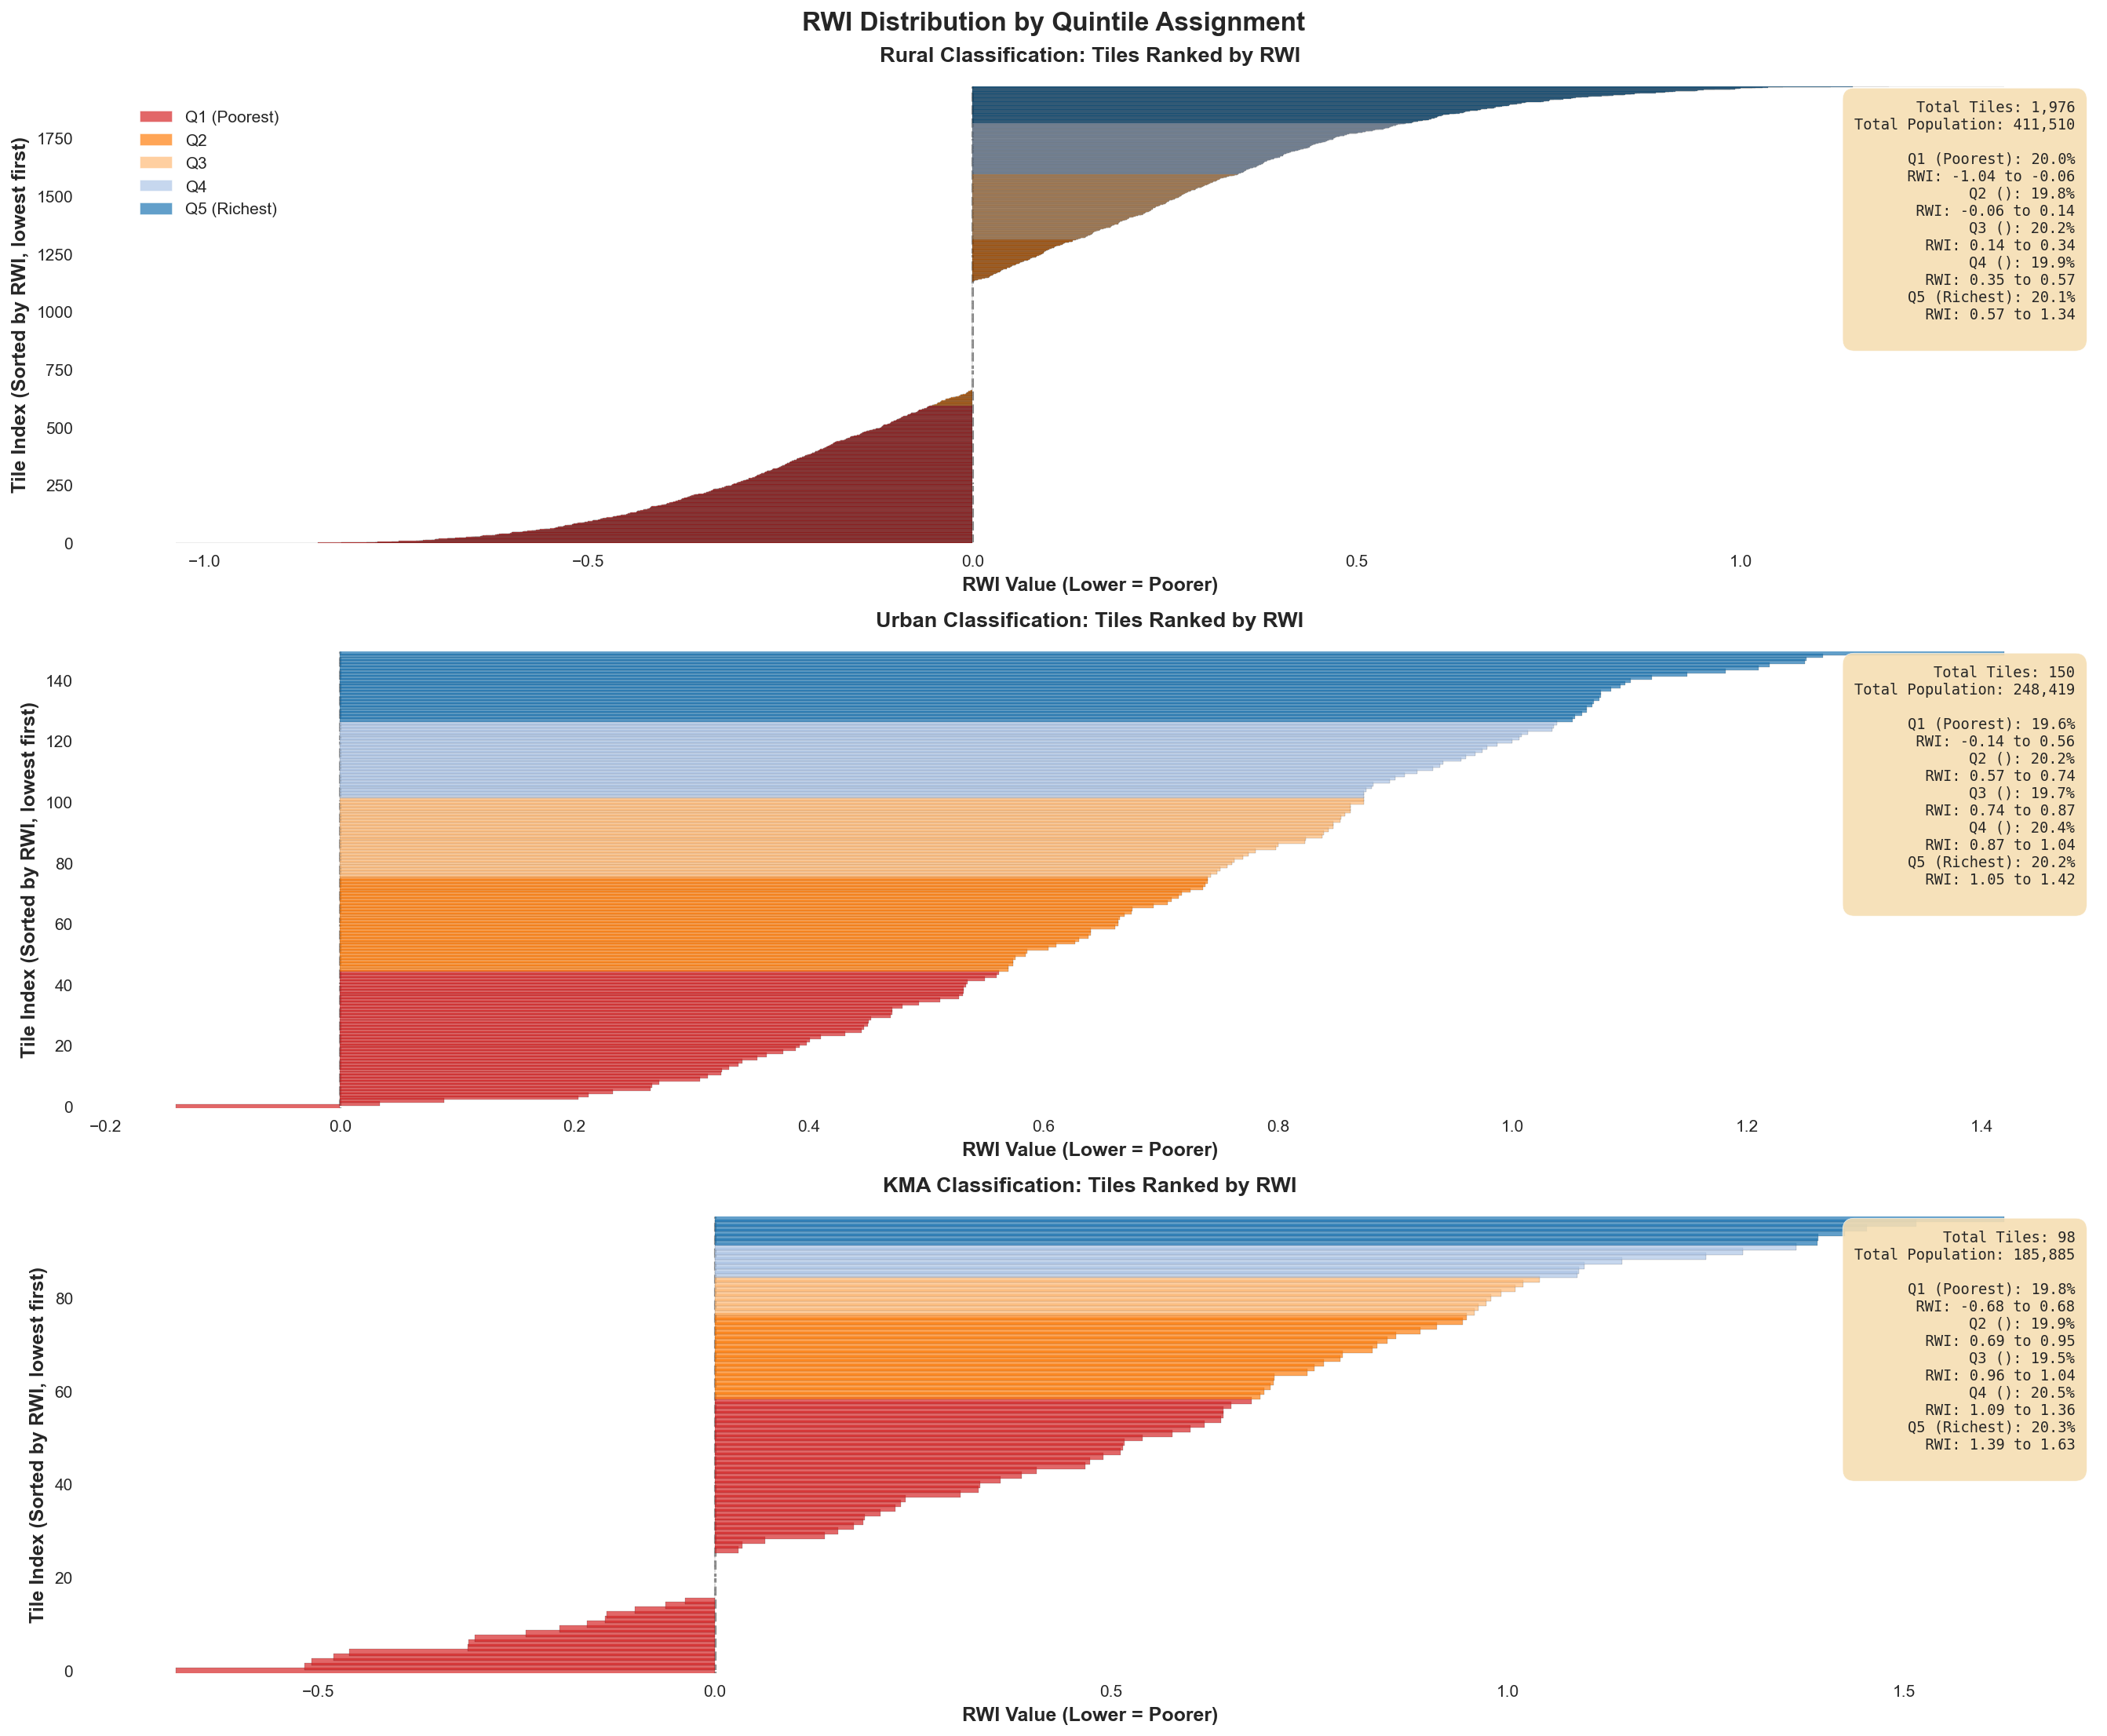

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(18, 15))
plt.subplots_adjust(hspace=0.4, top=0.95)

# Color scheme for quintiles (Q1=poorest to Q5=richest)
quintile_colors = {
    1: '#d62728',  # Red - Poorest
    2: '#ff7f0e',  # Orange
    3: '#ffbb78',  # Light Orange
    4: '#aec7e8',  # Light Blue
    5: '#1f77b4'   # Blue - Richest
}

quintile_labels = {
    1: 'Q1 (Poorest)',
    2: 'Q2',
    3: 'Q3',
    4: 'Q4',
    5: 'Q5 (Richest)'
}

for idx, region in enumerate(['Rural', 'Urban', 'KMA']):
    ax = axes[idx]
    
    # Filter for this region
    mask_region = gdf_results['area_classification'] == region
    gdf_region = gdf_results[mask_region].copy()
    
    if len(gdf_region) == 0:
        ax.text(0.5, 0.5, f'No data for {region}', ha='center', va='center', 
                transform=ax.transAxes, fontsize=14)
        ax.set_title(f'{region} Classification', fontsize=14, fontweight='bold', pad=10)
        continue
    
    # Sort by RWI for visualization
    gdf_region_sorted = gdf_region.sort_values('rwi', ascending=True).reset_index(drop=True)
    
    # Create horizontal bar chart where each tile is represented by a bar
    # Bars are positioned at their RWI value and colored by quintile
    tile_indices = np.arange(len(gdf_region_sorted))
    
    # Plot bars for each quintile
    # Bars extend from RWI = 0 to each tile's RWI value
    for quintile in [1, 2, 3, 4, 5]:
        q_mask = gdf_region_sorted['wealth_quintile'] == quintile
        q_tiles = gdf_region_sorted[q_mask]
        
        if len(q_tiles) > 0:
            # Get positions and RWI values for this quintile
            q_positions = q_tiles.index.values
            q_rwi_values = q_tiles['rwi'].values
            
            num_tiles = len(gdf_region_sorted)

            if num_tiles > 1000:
                bar_height = 0.8
                bar_height = 1.2
            else:
                bar_height = 1.5
            

            for i, (pos, rwi) in enumerate(zip(q_positions, q_rwi_values)):
                ax.barh(pos, rwi, height=bar_height, left=0,
                       color=quintile_colors[quintile], alpha=0.7, 
                       edgecolor='black', linewidth=0.1,
                       label=quintile_labels[quintile] if (idx == 0 and i == 0) else '')
    
    # Add vertical line at RWI = 0 for reference
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5, zorder=0)
    
    # Set axis limits
    rwi_min = gdf_region_sorted['rwi'].min()
    rwi_max = gdf_region_sorted['rwi'].max()
    rwi_range = rwi_max - rwi_min
    ax.set_xlim(rwi_min - rwi_range*0.05, rwi_max + rwi_range*0.05)
    ax.set_ylim(-0.5, len(gdf_region_sorted) - 0.5)
    
    # Customize axes
    ax.set_xlabel('RWI Value (Lower = Poorer)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Tile Index (Sorted by RWI, lowest first)', fontsize=12, fontweight='bold')
    # Simplified title to avoid overlap
    ax.set_title(f'{region} Classification: Tiles Ranked by RWI', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3, axis='x')
    
    if idx == 0:
        # Create custom legend entries
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=quintile_colors[q], alpha=0.7, 
                                 label=quintile_labels[q]) for q in [1, 2, 3, 4, 5]]
        ax.legend(handles=legend_elements, loc='upper left', fontsize=10, 
                 framealpha=0.9, bbox_to_anchor=(0.02, 0.98))
    
    # Add summary text box
    summary_text = f"Total Tiles: {len(gdf_region_sorted):,}\n"
    summary_text += f"Total Population: {gdf_region_sorted['children_population'].sum():,.0f}\n\n"
    
    for quintile in [1, 2, 3, 4, 5]:
        q_mask = gdf_region_sorted['wealth_quintile'] == quintile
        q_tiles = gdf_region_sorted[q_mask]
        if len(q_tiles) > 0:
            q_pop = q_tiles['children_population'].sum()
            q_pop_pct = (q_pop / gdf_region_sorted['children_population'].sum() * 100)
            q_rwi_min = q_tiles['rwi'].min()
            q_rwi_max = q_tiles['rwi'].max()
            q_label = 'Poorest' if quintile == 1 else 'Richest' if quintile == 5 else ''
            summary_text += f"Q{quintile} ({q_label}): {q_pop_pct:.1f}%\n"
            summary_text += f"  RWI: {q_rwi_min:.2f} to {q_rwi_max:.2f}\n"
    
    # Position text box better
    ax.text(0.99, 0.97, summary_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, pad=0.8),
            family='monospace')


plt.tight_layout(rect=[0, 0, 1, 0.97]) 
plt.suptitle('RWI Distribution by Quintile Assignment\n', 
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

## Children Population Distribution by RWI Ranking

  Saved: analysis_output/quintile_method/visualizations/children_population_distribution_by_rwi_ranking_.png


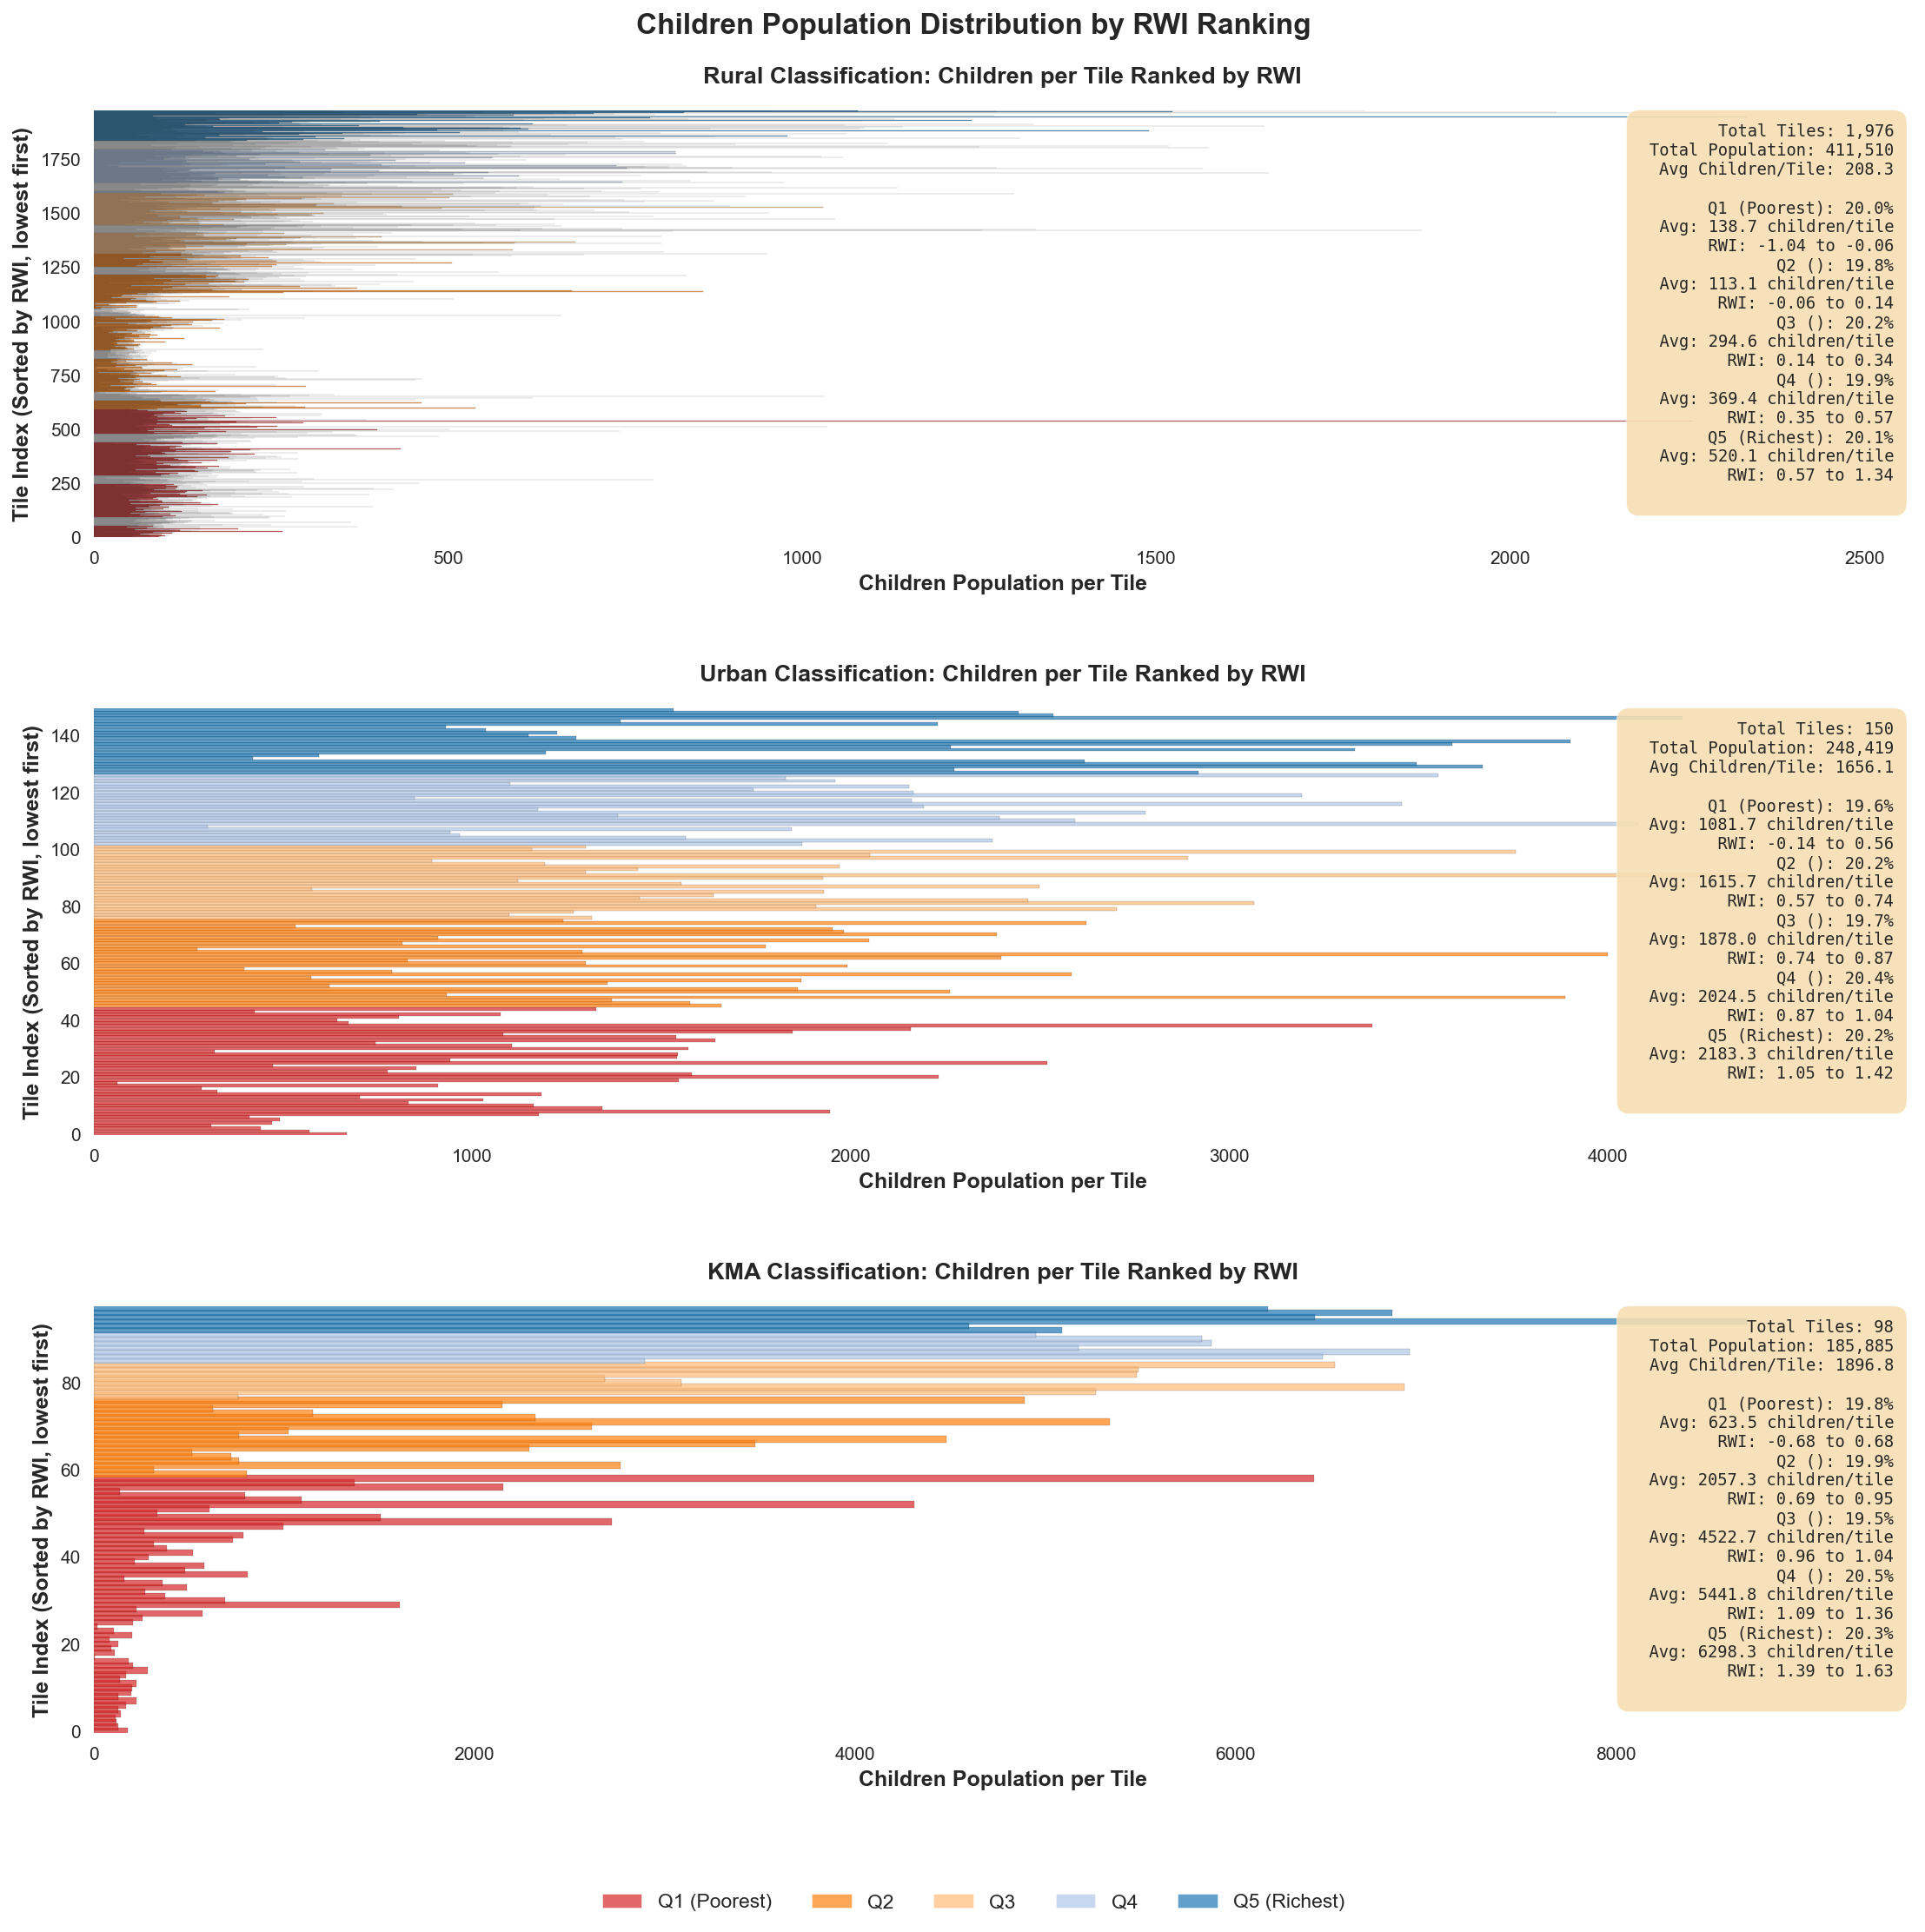

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(18, 15))

plt.subplots_adjust(hspace=0.4, top=0.95, bottom=0.12)

# Color scheme for quintiles (same as before)
quintile_colors = {
    1: '#d62728',  # Red - Poorest
    2: '#ff7f0e',  # Orange
    3: '#ffbb78',  # Light Orange
    4: '#aec7e8',  # Light Blue
    5: '#1f77b4'   # Blue - Richest
}

quintile_labels = {
    1: 'Q1 (Poorest)',
    2: 'Q2',
    3: 'Q3',
    4: 'Q4',
    5: 'Q5 (Richest)'
}

for idx, region in enumerate(['Rural', 'Urban', 'KMA']):
    ax = axes[idx]
    
    # Filter for this region
    mask_region = gdf_results['area_classification'] == region
    gdf_region = gdf_results[mask_region].copy()
    
    if len(gdf_region) == 0:
        ax.text(0.5, 0.5, f'No data for {region}', ha='center', va='center', 
                transform=ax.transAxes, fontsize=14)
        ax.set_title(f'{region} Classification', fontsize=14, fontweight='bold', pad=10)
        continue
    
    # Sort by RWI for visualization
    gdf_region_sorted = gdf_region.sort_values('rwi', ascending=True).reset_index(drop=True)
    
    # Create horizontal bar chart where each tile is represented by a bar
    # Bars are positioned by tile index (ranked by RWI), length represents children population
    tile_indices = np.arange(len(gdf_region_sorted))
    
    # Plot bars for each quintile
    for quintile in [1, 2, 3, 4, 5]:
        q_mask = gdf_region_sorted['wealth_quintile'] == quintile
        q_tiles = gdf_region_sorted[q_mask]
        
        if len(q_tiles) > 0:
            # Get positions and children population for this quintile
            q_positions = q_tiles.index.values
            q_children = q_tiles['children_population'].values
            
            num_tiles = len(gdf_region_sorted)

            if num_tiles > 1000:
                bar_height = 0.8 
            elif num_tiles > 100:
                bar_height = 1.2
            else:
                bar_height = 1.5
            
            for i, (pos, children) in enumerate(zip(q_positions, q_children)):
                ax.barh(pos, children, height=bar_height, left=0,
                       color=quintile_colors[quintile], alpha=0.7, 
                       edgecolor='black', linewidth=0.1)
    
    # Set axis limits
    max_children = gdf_region_sorted['children_population'].max()
    ax.set_xlim(0, max_children * 1.1)  # Add 10% padding
    ax.set_ylim(-0.5, len(gdf_region_sorted) - 0.5)
    
    # Customize axes
    ax.set_xlabel('Children Population per Tile', fontsize=12, fontweight='bold')
    ax.set_ylabel('Tile Index (Sorted by RWI, lowest first)', fontsize=12, fontweight='bold')
    ax.set_title(f'{region} Classification: Children per Tile Ranked by RWI', 
                 fontsize=13, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add summary text box
    summary_text = f"Total Tiles: {len(gdf_region_sorted):,}\n"
    summary_text += f"Total Population: {gdf_region_sorted['children_population'].sum():,.0f}\n"
    summary_text += f"Avg Children/Tile: {gdf_region_sorted['children_population'].mean():.1f}\n\n"
    
    for quintile in [1, 2, 3, 4, 5]:
        q_mask = gdf_region_sorted['wealth_quintile'] == quintile
        q_tiles = gdf_region_sorted[q_mask]
        if len(q_tiles) > 0:
            q_pop = q_tiles['children_population'].sum()
            q_pop_pct = (q_pop / gdf_region_sorted['children_population'].sum() * 100)
            q_avg_children = q_tiles['children_population'].mean()
            q_rwi_min = q_tiles['rwi'].min()
            q_rwi_max = q_tiles['rwi'].max()
            q_label = 'Poorest' if quintile == 1 else 'Richest' if quintile == 5 else ''
            summary_text += f"Q{quintile} ({q_label}): {q_pop_pct:.1f}%\n"
            summary_text += f"  Avg: {q_avg_children:.1f} children/tile\n"
            summary_text += f"  RWI: {q_rwi_min:.2f} to {q_rwi_max:.2f}\n"
    
    ax.text(0.99, 0.97, summary_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, pad=0.8),
            family='monospace')

# Create legend at the bottom of the figure (below all subplots)
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=quintile_colors[q], alpha=0.7, 
                         label=quintile_labels[q]) for q in [1, 2, 3, 4, 5]]
fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=11, 
          framealpha=0.9, bbox_to_anchor=(0.5, 0.02))

plt.suptitle('Children Population Distribution by RWI Ranking\n', 
             fontsize=16, fontweight='bold', y=1)
plt.show()

## Population-Weighted Average RWI by Quintile

Calculate the population-weighted average RWI for each quintile per classification.

$\overline{RWI} =\frac {\sum{(RWI_i × Pop_i)}} {\sum{Pop_i}}$


In [15]:
# Calculate population-weighted average RWI for each quintile per classification
quintile_rwi_summary = []

for region in ['Rural', 'Urban', 'KMA']:
    mask = gdf_results['area_classification'] == region
    df_region = gdf_results[mask].copy()
    
    if len(df_region) == 0:
        continue
    
    # Group by quintile and calculate population-weighted average RWI
    for quintile in [1, 2, 3, 4, 5]:
        q_mask = df_region['wealth_quintile'] == quintile
        q_tiles = df_region[q_mask]
        
        if len(q_tiles) > 0:
            # Population-weighted average RWI: sum(RWI_i * Pop_i) / sum(Pop_i)
            weighted_avg_rwi = (q_tiles['rwi'] * q_tiles['children_population']).sum() / q_tiles['children_population'].sum()
            
            # Also calculate simple average for comparison
            simple_avg_rwi = q_tiles['rwi'].mean()
            
            # Get other statistics
            total_pop = q_tiles['children_population'].sum()
            num_tiles = len(q_tiles)
            rwi_min = q_tiles['rwi'].min()
            rwi_max = q_tiles['rwi'].max()
            rwi_median = q_tiles['rwi'].median()
            
            quintile_rwi_summary.append({
                'classification': region,
                'quintile': quintile,
                'quintile_label': f'Q{quintile} ({"Poorest" if quintile == 1 else "Richest" if quintile == 5 else ""})',
                'num_tiles': num_tiles,
                'total_population': total_pop,
                'weighted_avg_rwi': weighted_avg_rwi,
                'simple_avg_rwi': simple_avg_rwi,
                'median_rwi': rwi_median,
                'min_rwi': rwi_min,
                'max_rwi': rwi_max,
                'rwi_range': rwi_max - rwi_min
            })

df_quintile_rwi = pd.DataFrame(quintile_rwi_summary)


for region in ['Rural', 'Urban', 'KMA']:
    region_data = df_quintile_rwi[df_quintile_rwi['classification'] == region]
    if len(region_data) > 0:
        print(f"\n{region}:")
        print(f"{'Quintile':<12} {'Tiles':<8} {'Population':<15} {'Weighted Avg RWI':<18} {'Simple Avg RWI':<18} {'Median RWI':<15}")
        print("-" * 80)
        for _, row in region_data.iterrows():
            print(f"{row['quintile_label']:<12} {row['num_tiles']:<8} {row['total_population']:>14,.0f} "
                  f"{row['weighted_avg_rwi']:>17.4f} {row['simple_avg_rwi']:>17.4f} {row['median_rwi']:>14.4f}")



Rural:
Quintile     Tiles    Population      Weighted Avg RWI   Simple Avg RWI     Median RWI     
--------------------------------------------------------------------------------
Q1 (Poorest) 593              82,275           -0.2807           -0.3092        -0.2770
Q2 ()        720              81,434            0.0262            0.0146         0.0000
Q3 ()        282              83,081            0.2452            0.2382         0.2390
Q4 ()        222              82,017            0.4412            0.4374         0.4325
Q5 (Richest) 159              82,704            0.7847            0.7453         0.7030

Urban:
Quintile     Tiles    Population      Weighted Avg RWI   Simple Avg RWI     Median RWI     
--------------------------------------------------------------------------------
Q1 (Poorest) 45               48,676            0.4144            0.3833         0.4010
Q2 ()        31               50,087            0.6542            0.6555         0.6640
Q3 ()        26       

  Saved: analysis_output/quintile_method/visualizations/rwi_distribution_with_population-weighted_average.png


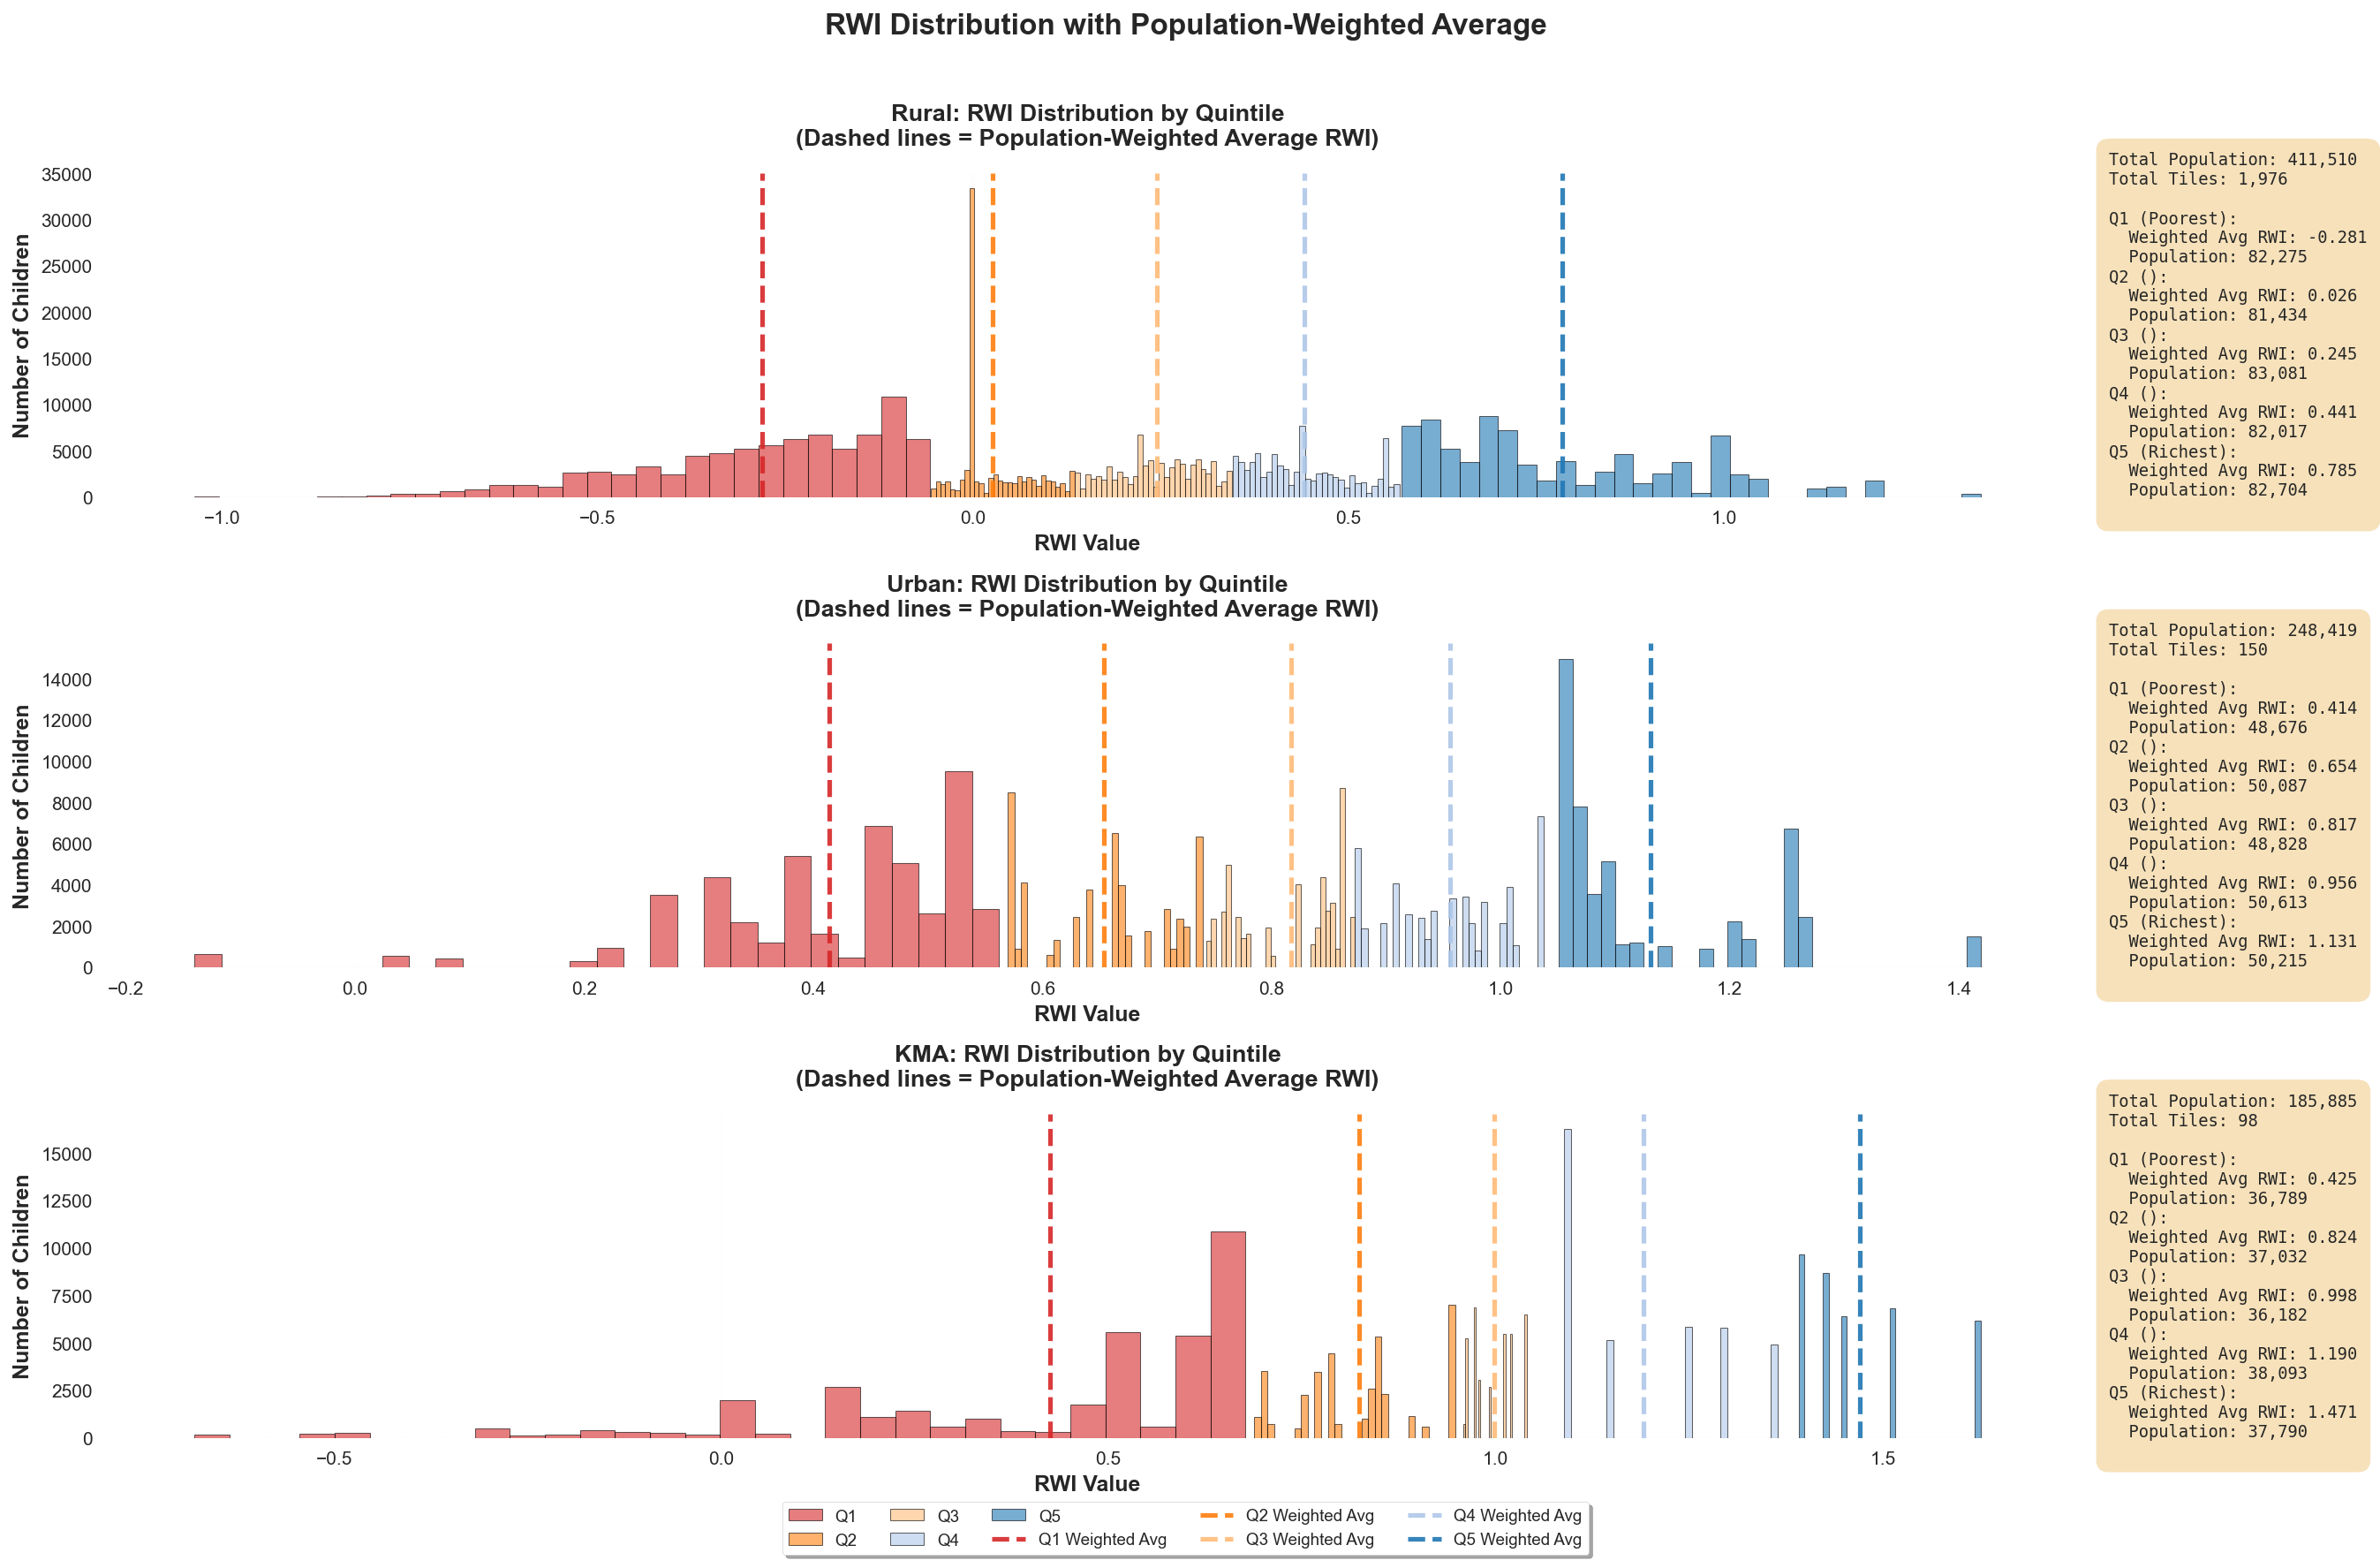

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, bottom=0.15, right=0.75)

# Collect handles and labels for unified legend
legend_handles = []
legend_labels = []

for idx, region in enumerate(['Rural', 'Urban', 'KMA']):
    ax = axes[idx]
    mask = gdf_results['area_classification'] == region
    df_region = gdf_results[mask].copy()
    
    if len(df_region) == 0:
        continue
    
    # Get region-specific data
    region_rwi_data = df_quintile_rwi[df_quintile_rwi['classification'] == region].sort_values('quintile')
    
    # Create histogram of RWI values, colored by quintile, weighted by children population
    for quintile in [1, 2, 3, 4, 5]:
        q_mask = df_region['wealth_quintile'] == quintile
        q_data = df_region.loc[q_mask]
        q_rwi = q_data['rwi'].values
        q_children = q_data['children_population'].values
        if len(q_rwi) > 0:
            # Only collect handles/labels from first subplot to avoid duplicates
            if idx == 0:
                n, bins, patches = ax.hist(q_rwi, bins=30, weights=q_children, alpha=0.6, label=f'Q{quintile}', 
                           color=quintile_colors[quintile], edgecolor='black', linewidth=0.5)
                if len(patches) > 0:
                    legend_handles.append(patches[0])
                    legend_labels.append(f'Q{quintile}')
            else:
                ax.hist(q_rwi, bins=30, weights=q_children, alpha=0.6, 
                       color=quintile_colors[quintile], edgecolor='black', linewidth=0.5)
    
    # Add vertical lines for population-weighted average RWI
    for _, row in region_rwi_data.iterrows():
        q = int(row['quintile'])
        weighted_avg = row['weighted_avg_rwi']
        # Only collect handles/labels from first subplot
        if idx == 0:
            vline = ax.axvline(x=weighted_avg, color=quintile_colors[q], linestyle='--', 
                      linewidth=2.5, alpha=0.9, 
                      label=f'Q{q} Weighted Avg')
            legend_handles.append(vline)
            legend_labels.append(f'Q{q} Weighted Avg')
        else:
            ax.axvline(x=weighted_avg, color=quintile_colors[q], linestyle='--', 
                  linewidth=2.5, alpha=0.9)
    
    # Add vertical line at RWI = 0
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.3, zorder=0)
    
    ax.set_xlabel('RWI Value', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Children', fontsize=12, fontweight='bold')
    ax.set_title(f'{region}: RWI Distribution by Quintile\n(Dashed lines = Population-Weighted Average RWI)', 
                fontsize=13, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add summary statistics
    total_pop = df_region['children_population'].sum()
    summary_text = f"Total Population: {total_pop:,.0f}\n"
    summary_text += f"Total Tiles: {len(df_region):,}\n\n"
    for _, row in region_rwi_data.iterrows():
        q = int(row['quintile'])
        q_label = 'Poorest' if q == 1 else 'Richest' if q == 5 else ''
        summary_text += f"Q{q} ({q_label}):\n"
        summary_text += f"  Weighted Avg RWI: {row['weighted_avg_rwi']:.3f}\n"
        summary_text += f"  Population: {row['total_population']:,.0f}\n"
    
    # Position text on the right side, vertically centered within each subplot
    ax.text(1.02, 0.5, summary_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='center', horizontalalignment='left',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9, pad=0.8),
           family='monospace')

plt.suptitle('RWI Distribution with Population-Weighted Average',
            fontsize=16, fontweight='bold', y=0.995)

# Add unified legend at the bottom
fig.legend(legend_handles, legend_labels, loc='lower center', ncol=5, fontsize=9, 
          bbox_to_anchor=(0.5, 0.02), frameon=True, fancybox=True, shadow=True)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])
plt.show()


## Export Results

In [17]:
# Export tiles with poverty probabilities and quintiles
output_file = "analysis_output/quintile_method/tiles_with_quintile_poverty.parquet"
os.makedirs("analysis_output", exist_ok=True)
gdf_results.to_parquet(output_file, index=False)
print(f"Exported tiles data to: {output_file}")

# Export summary statistics
summary_file = "analysis_output/quintile_method/quintile_based_poverty_summary.csv"
df_stats.to_csv(summary_file, index=False)
print(f"Exported summary statistics to: {summary_file}")

# Export parish-level summary
parish_summary = gdf_results.groupby(['parish', 'area_classification']).agg({
    'children_population': 'sum',
    'poor_children': 'sum',
    'poverty_prob': 'mean'
}).reset_index()
parish_summary['poverty_rate'] = (parish_summary['poor_children'] / parish_summary['children_population'] * 100)

parish_file = "analysis_output/quintile_method/quintile_based_parish_summary.csv"
parish_summary.to_csv(parish_file, index=False)
print(f"Exported parish summary to: {parish_file}")

# Export population-weighted RWI summary
rwi_summary_file = "analysis_output/quintile_method/quintile_population_weighted_rwi_summary.csv"
df_quintile_rwi.to_csv(rwi_summary_file, index=False)
print(f"Exported population-weighted RWI summary to: {rwi_summary_file}")

Exported tiles data to: analysis_output/quintile_method/tiles_with_quintile_poverty.parquet
Exported summary statistics to: analysis_output/quintile_method/quintile_based_poverty_summary.csv
Exported parish summary to: analysis_output/quintile_method/quintile_based_parish_summary.csv
Exported population-weighted RWI summary to: analysis_output/quintile_method/quintile_population_weighted_rwi_summary.csv
